# Прогноз оттока клиентов банка 

## Получение и изучение данных

### Поставленная задача и исходные данные

**Заказчик: «Бета-Банк»**

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

**Исходные данные**
Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.


**Задачи**
- Спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.
- Построить модель с предельно большим значением *F1*-меры - не менее 0.59.
- Проверить *F1*-меру на тестовой выборке.
- Дополнительно измерить *AUC-ROC*, сравнивая её значение с *F1*-мерой.

**Описание данных**

*Признаки*
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

*Целевой признак*
- `Exited` — факт ухода клиента

### Обзор данных

<ins>Импорт библиотек</ins>

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')
import random
import warnings
warnings.filterwarnings("ignore") # отключаем предупреждения
pd.options.mode.chained_assignment = None # отключаем предупреждения pandas
import re
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, make_scorer,
                             classification_report,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             recall_score,
                             precision_score,
                             roc_curve,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                             roc_auc_score )
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyClassifier

<ins>Чтение файлов с данными</ins>

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

<ins>Изучение общей информации о данных и внесение корректировок на основе наблюдений</ins>

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Наблюдения:
- наименования столбцов необходимо привести к "змеиному" регистру
- столбцы, неимеющие связи с отоком клиентов: `RowNumber`, `CustomerId`, `Surname`
- пропуски в столбце `Tenure`

Приведем столбцы к "змеиному регистру"

In [4]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]

Удалим ненужные столбцы

In [5]:
df.drop(['row_number', 'customer_id', 'surname'], axis = 1, inplace=True)

Доля пропущенных значений в столбце `tenure` (сколько лет человек является клиентом банка)

In [6]:
df['tenure'].isna().mean()

0.0909

Посмотрим на количество и процент клиентов в зависимости от количества лет сотрудничества с банком

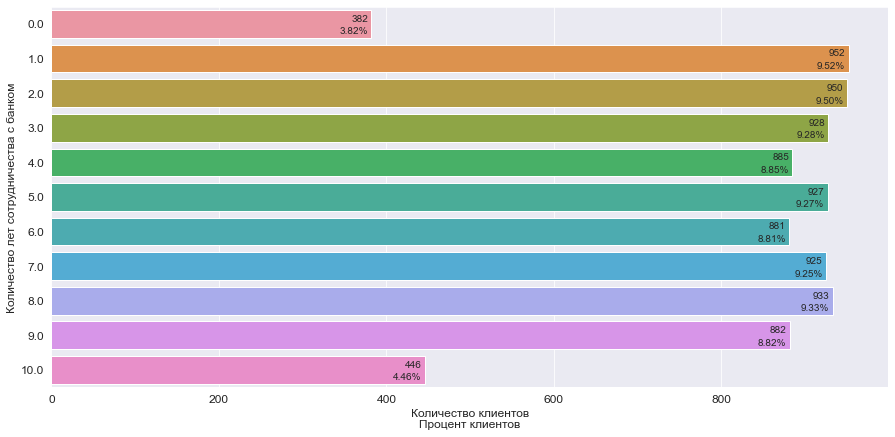

In [7]:
plt.figure(figsize=(15, 7))

ax = sns.countplot(data=df, y='tenure', hue='tenure', dodge=False)

plt.xlabel('Количество клиентов\nПроцент клиентов', fontsize=12)
plt.ylabel('Количество лет сотрудничества с банком', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.get_legend().remove()

total = len(df)
for p in ax.patches:
        ax.annotate('{:.2f}%'.format(100 * p.get_width()/total),
                    (p.get_x() + p.get_width() -10, p.get_y() + p.get_height()/1.3),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='right',
                    va='center')
        ax.annotate('%.0f' % p.get_width(),
                    (p.get_x() + p.get_width() -10, p.get_y() + p.get_height()/3.2),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='right',
                    va='center')   

Большинство клиентов сотрудничают с банком от 1 до 9 лет из 10, их процент примерно одинаков, около 9%, такой же, как и процент пропущенных значений, клиентов, сотрудничащих с банком менее 1 года и 10 лет примерно по 4%.

Посмотрим визуально, есть ли взаимосвязь с другими данными в строках с пропусками.

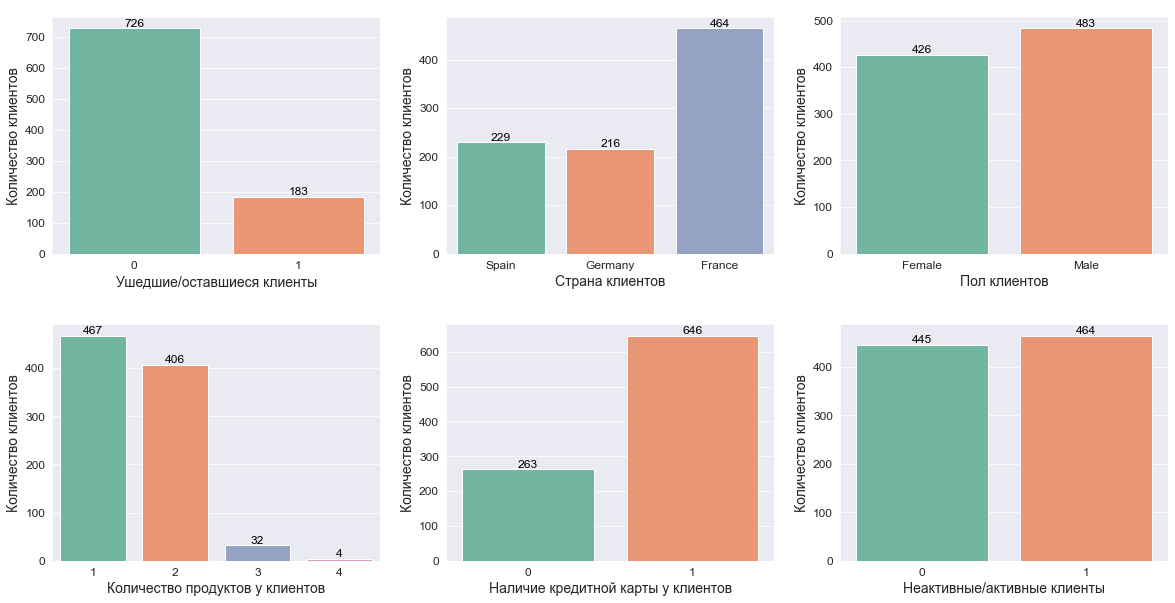

In [8]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

columns = ['exited','geography', 'gender', 'num_of_products','has_cr_card','is_active_member']
x_titles = ['Ушедшие/оставшиеся клиенты',
            'Страна клиентов',
            'Пол клиентов',
            'Количество продуктов у клиентов',
            'Наличие кредитной карты у клиентов',
            'Неактивные/активные клиенты']

for i in range(len(columns)):
    fig = plt.subplot(2, 3, i+1)    
    ax = sns.countplot(data=df[df['tenure'].isna()==True], x=columns[i])
    plt.xlabel(x_titles[i], fontsize=14)
    plt.ylabel('Количество клиентов', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    total = len(df[df['tenure'].isna()==True])
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}',
                    (p.get_x()+0.4, p.get_height()),
                    color='black',
                    size=12,
                    ha='center',
                    va='bottom')

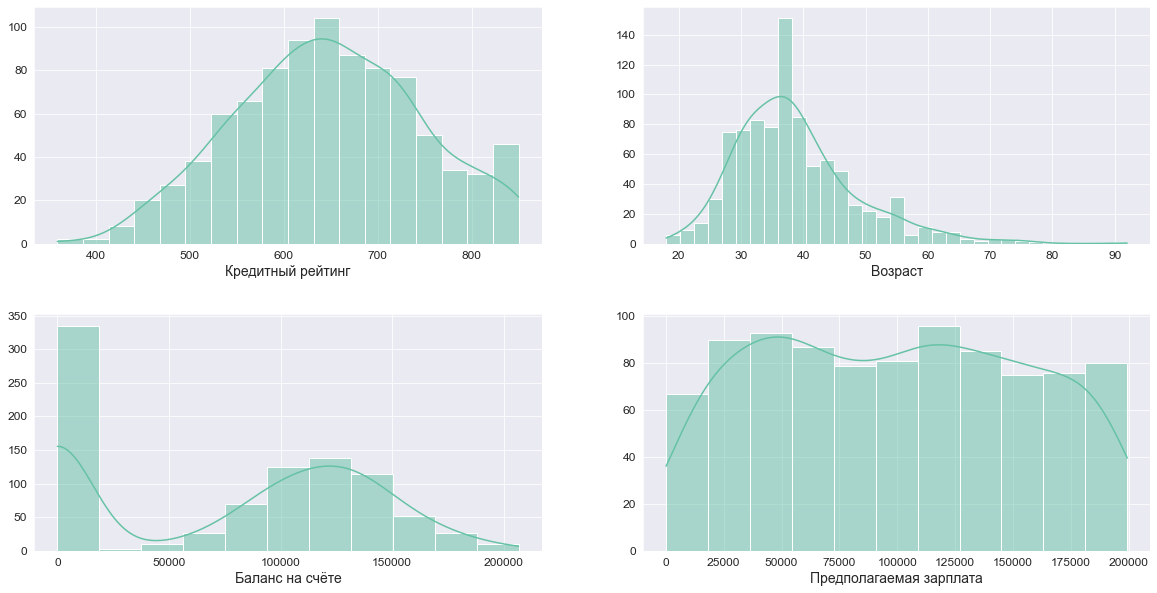

In [9]:
quantity_nan = df[df['tenure'].isna()==True][['credit_score', 'age', 'balance', 'estimated_salary']]

plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

columns = list(quantity_nan.columns)
x_titles = ['Кредитный рейтинг',
            'Возраст',
            'Баланс на счёте',
            'Предполагаемая зарплата']

for i in range(len(columns)):
    fig = plt.subplot(2, 2, i+1)    
    ax = sns.histplot(data=quantity_nan, x=columns[i], kde=True)
    ax.set(ylabel=None)
    plt.xlabel(x_titles[i], fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

Закономерностей не найдено. В данных по всем остальным столбцам при фильтрации по пропущенным значениям в столбце `tenure` визуально наблюдается разнообразие всей информации из датасета.

Большинство клиентов сотрудничают с банком от 1 до 9 лет из 10, их процент примерно одинаков, около 9%, такой же, как и процент пропущенных значений, клиентов, сотрудничащих с банком менее 1 года и 10 лет примерно по 4%.

В признаке `tenure` дискретные данные.

Хотелось бы сохранить весь датасет для построения более предсказуемой модели на основании бо́льших данных.

Т.к. далее будет производиться масштабирование признаков, заменим пропуски случайными целыми числами в диапазоне от 0 до 10, чтобы не изменять текущую картину.

In [10]:
nan_replace = []

for i in df.loc[df['tenure'].isna(),'tenure'].index:
    random.seed(i)
    nan_replace.append(random.randint(0,10))
    
df.loc[df['tenure'].isna(),'tenure'] = nan_replace

df.loc[df['tenure'].isna(),'tenure'] = df.loc[df['tenure'].isna(),'tenure'].apply(lambda x: random.randint(0,10))

Проверим данные на наличие явных дубликатов

In [11]:
f'Количество дубликатов: {df.duplicated().sum()}'

'Количество дубликатов: 0'

<ins>Посмотрим на доли клиентов по различным признакам</ins>

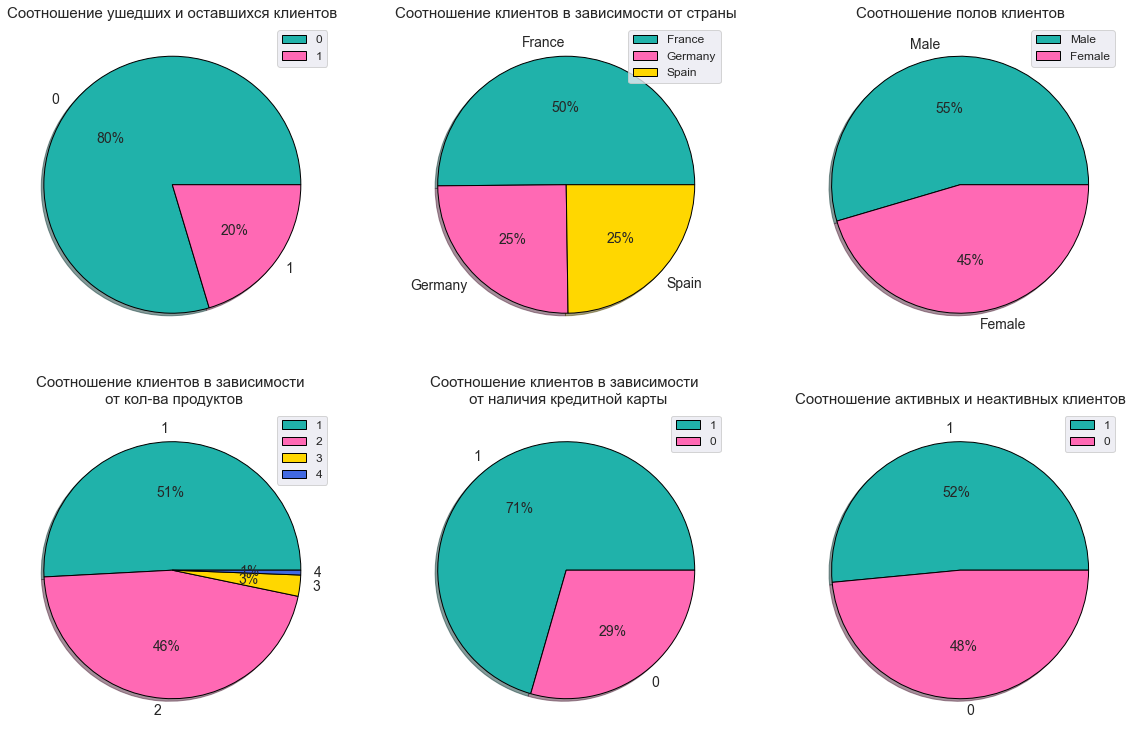

In [12]:
columns = ['exited', 'geography', 'gender', 'num_of_products','has_cr_card','is_active_member']

fig = plt.figure(figsize=(20, 13))

axes = []

titles = ['Соотношение ушедших и оставшихся клиентов',
        'Соотношение клиентов в зависимости от страны',
        'Соотношение полов клиентов',
        'Соотношение клиентов в зависимости \n от кол-ва продуктов',
        'Соотношение клиентов в зависимости \n от наличия кредитной карты',
        'Соотношение активных и неактивных клиентов']

for i in range(len(columns)):
    axes.append(fig.add_subplot(2, 3, i+1))
    pie_clients=df[columns[i]].value_counts().plot(kind='pie',
                                                   legend=True,
                                                   label='',
                                                   autopct='%1.0f%%',
                                                   title=titles[i],
                                                   shadow=True,
                                                   wedgeprops={'lw':1, 'ls':'-','edgecolor':"k"},
                                                   ax=axes[i],
                                                   colors = ['lightseagreen', 'hotpink', 'gold', 'royalblue'],
                                                   fontsize=14)
    pie_clients.legend(fontsize=12)
    axes[i].title.set_size(15)

- ушедших клиентов 20%
- половина клиентов из Франции, четверть - из Германии, четверть - из Испании
- мужчин больше на 10%, чем женщин
- большинство клиентов с 1-2 продуктами, с 1 продуктом больше на 5%, чем с двумя
- клиентов с кредитной картой больше в 2,5 раза, чем без неё
- активных и неактивных клиентов примерно одинаковое количество, активных больше на 4%

<ins>Посмотрим на количество клиентов по различным признакам</ins>

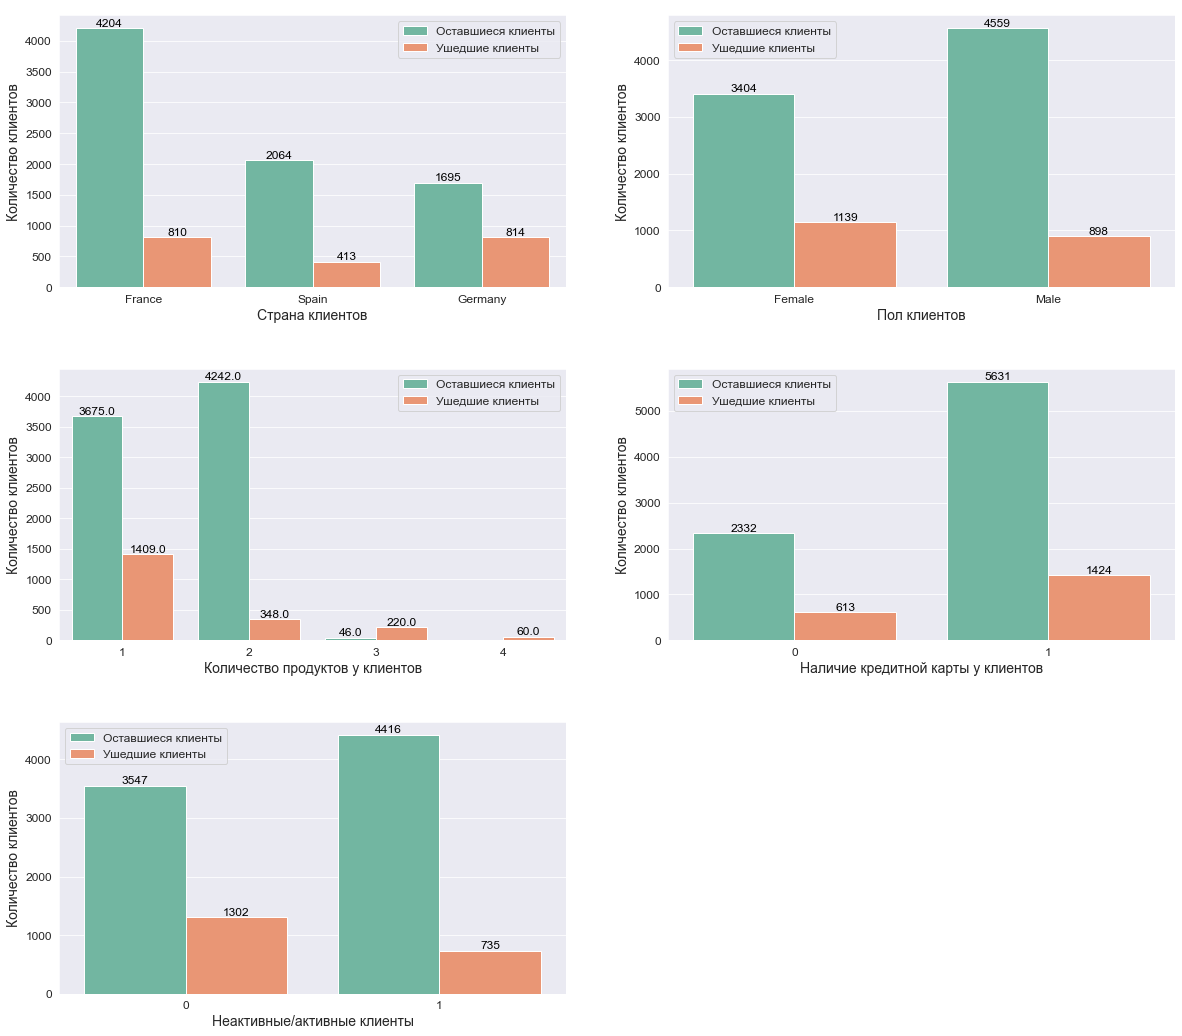

In [13]:
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

columns = ['geography', 'gender', 'num_of_products','has_cr_card','is_active_member']
x_titles = ['Страна клиентов',
            'Пол клиентов',
            'Количество продуктов у клиентов',
            'Наличие кредитной карты у клиентов',
            'Неактивные/активные клиенты']

for i in range(len(columns)):
    fig = plt.subplot(3, 2, i+1)    
    ax = sns.countplot(data=df, x=columns[i], hue='exited')
    plt.xlabel(x_titles[i], fontsize=14)
    plt.ylabel('Количество клиентов', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(["Оставшиеся клиенты", "Ушедшие клиенты"], fontsize=12);
    
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=12, ha="center", va='bottom')

Наблюдается значительный дисбаланс классов в целевом признаке.

<ins>Посмотрим, как коррелируют количественные признаки друг с другом в столбцах:</ins>
- `credit_score` (кредитный рейтинг),
- `age` — возраст
- `balance` (баланс на счёте),
- `estimated_salary` (предполагаемая зарплата)

<ins>в зависимости от значения целевого признака</ins>

In [14]:
df_quantity = df[['credit_score', 'age', 'balance', 'estimated_salary', 'exited']]
df_quantity.loc[df_quantity['exited'] == 0, 'exited'] = 'Оставшиеся клиенты'
df_quantity.loc[df_quantity['exited'] == 1, 'exited'] = 'Ушедшие клиенты'

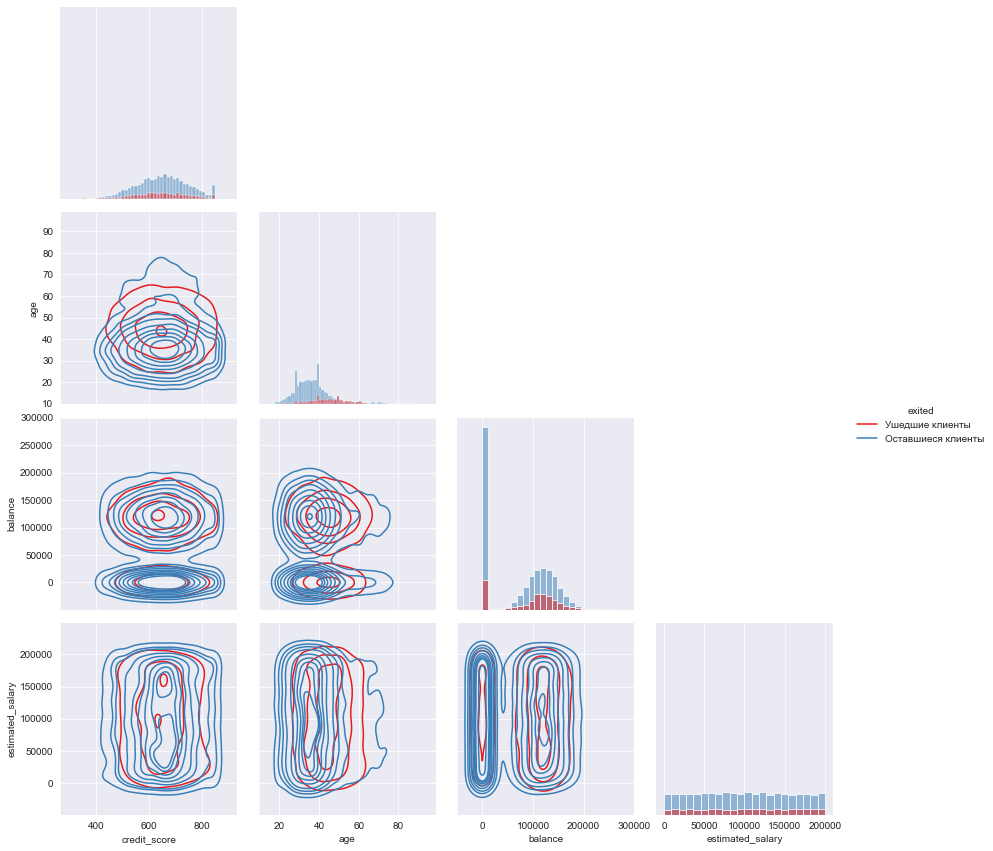

In [15]:
sns.pairplot(df_quantity, hue='exited', palette='Set1', kind = 'kde', diag_kind='hist', corner=True, height=3);

In [16]:
df_quantity.describe()

,credit_score,age,balance,estimated_salary
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.889288,100090.239881
std,96.653299,10.487806,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,11.580000
25%,584.000000,32.000000,0.000000,51002.110000
50%,652.000000,37.000000,97198.540000,100193.915000
75%,718.000000,44.000000,127644.240000,149388.247500
max,850.000000,92.000000,250898.090000,199992.480000


Большинство клиентов:
- с кредитным рейтингом от 400 до 800
- от 20 до 60 лет
- с балансом на счёте от 0 до 200000
- с предполагаемой зарплатой от 0 до 200000

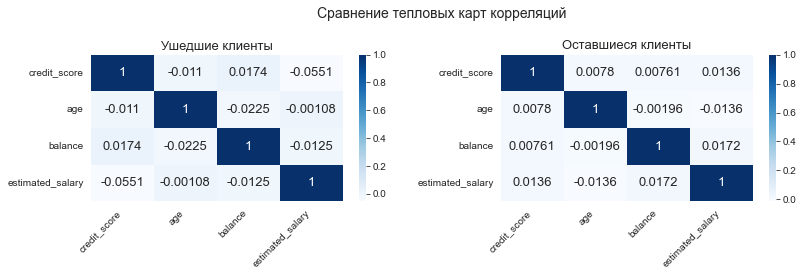

In [17]:
fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(13,3))
fig.autofmt_xdate(rotation=45)
fig.subplots_adjust(wspace=0.3)

fig.suptitle('Сравнение тепловых карт корреляций', y = 1.1, fontsize = 14)

ax0.set_title('Ушедшие клиенты', fontsize=13)
ax1.set_title('Оставшиеся клиенты', fontsize=13)

sns.heatmap(df_quantity[df_quantity['exited']=='Ушедшие клиенты'].set_index('exited').corr(),
            annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g', ax=ax0)

sns.heatmap(df_quantity[df_quantity['exited']=='Оставшиеся клиенты'].set_index('exited').corr(),
            annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g', ax=ax1);

Корреляция в количественных признаках отсутствует, что подтверждает графическая информация.

<ins>Итог.</ins>

Данные изучены и откорректированы.

Приступим к следующему шагу.

## Подготовка данных

Преобразуем категориальные признаки в численные техникой прямого кодирования (англ. One-Hot Encoding, OHE), т.к. она работает со всеми моделями.

Новые признаки - дамми-признаками (англ. dummy variable, «фиктивная переменная»).

Для прямого кодирования воспользуемся функцией pd.get_dummies() из библиотеки pandas (от англ. «получить фиктивные переменные») с исключением попадания в дамми-ловушку (англ. dummy trap, «ловушка фиктивных признаков»), указав значение аргумента `drop_first=True`.

In [18]:
df_ohe=pd.get_dummies(df,drop_first=True)

Создадим переменные для признаков и целевого признака

In [19]:
target = df_ohe['exited']
features = df_ohe.drop('exited', axis=1)

Разделим исходные данные на обучающую, валидационную и тестовую выборки.

In [20]:
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              test_size=.4,
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                            target_valid,
                                                                            test_size=.5,
                                                                            random_state=12345)

Проверим размеры выборок

In [21]:
for col in ['features_train', 'target_train', 'features_valid', 'target_valid', 'features_test', 'target_test']:
    print(f'размер выборки {col} : {locals()[col].shape}')

размер выборки features_train : (6000, 11)
размер выборки target_train : (6000,)
размер выборки features_valid : (2000, 11)
размер выборки target_valid : (2000,)
размер выборки features_test : (2000, 11)
размер выборки target_test : (2000,)


Отобразим долевое соотношение размеров выборок графически

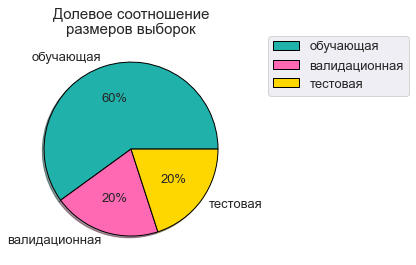

In [22]:
selections = pd.Series({'обучающая': len(target_train),
                        'валидационная': len(target_valid),
                        'тестовая': len(target_test)})

fig = plt.figure(figsize=(10, 4))

pie_selections=selections.plot(kind='pie',
                               legend=True,
                               label='',
                               autopct='%1.0f%%',
                               title='Долевое соотношение\nразмеров выборок',
                               shadow=True,
                               wedgeprops={'lw':1, 'ls':'-','edgecolor':"k"},
                               colors = ['lightseagreen', 'hotpink', 'gold'],
                               fontsize=13)
pie_selections.legend(bbox_to_anchor=(1.1, 1.05), fontsize=13)
pie_selections.title.set_size(15)

Посмотрим на масштаб признаков

In [23]:
features.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


Т.к. у признаков разный масштаб, необходимо их стандартизировать - привести к одному масштабу

In [24]:
numeric = list(features.columns)

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Проверим результаты масштабирования графически

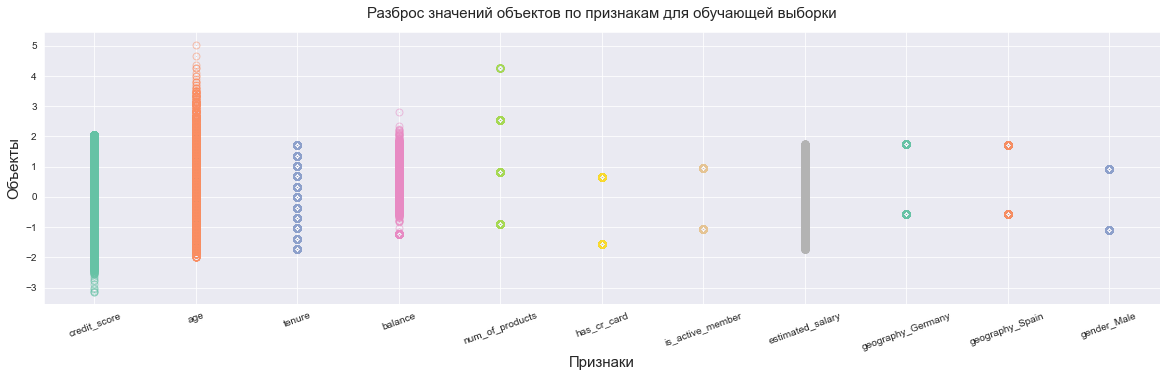

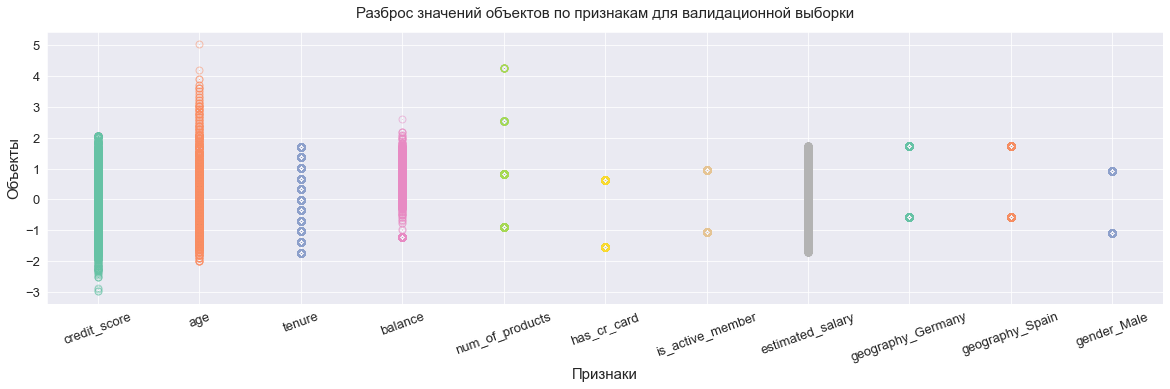

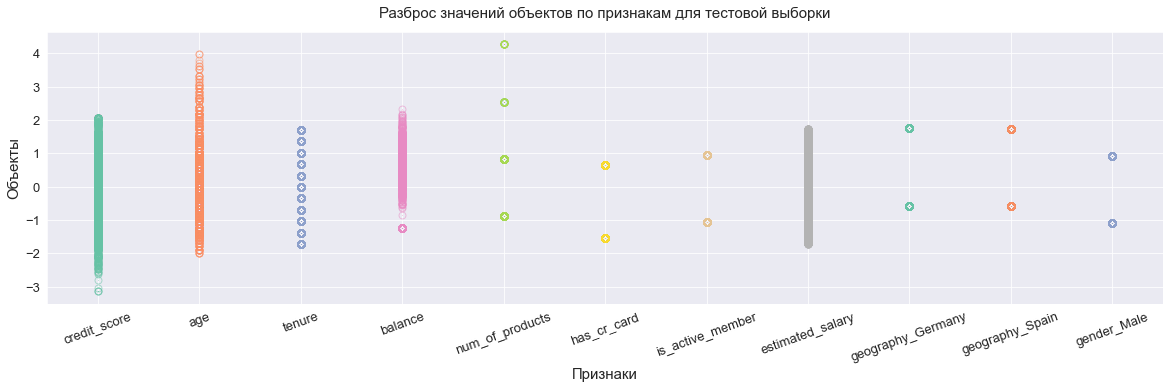

In [25]:
selection = ['features_train','features_valid','features_test']
title = ['Разброс значений объектов по признакам для обучающей выборки',
         'Разброс значений объектов по признакам для валидационной выборки',
         'Разброс значений объектов по признакам для тестовой выборки']

for i in range(3):

    fig, ax = plt.subplots(figsize=(20,5)) 
    
    for column in list(locals()[selection[i]].columns):
        ax.scatter([column]*len(locals()[selection[i]]), locals()[selection[i]][column], alpha=.5, linewidth=7, s = 1)
    
    ax.set_xlabel('Признаки', fontsize=15)
    ax.set_ylabel('Объекты', fontsize=15)
    plt.title(title[i], fontsize=15, y=1.03)
    plt.xticks(rotation = 20)
    plt.rcParams['font.size'] = '13'
    plt.show()

Признаки приведены к одному масштабу.

<ins>В результате подготовки данных выполнено:</ins>
- кодирование,
- деление на обучающую, валидационную и тестовую выборки,
- масштабирование.

## Исследование баланса классов

В результате ранее проведенного анализа наблюдается значительный дисбаланс классов.

Напомним соотношение классов в целевом признаке.

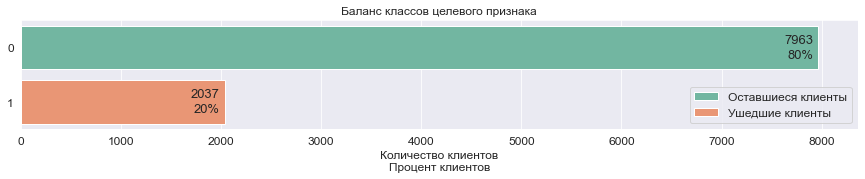

In [26]:
plt.figure(figsize=(15, 2))

ax = sns.countplot(data=df_ohe, y='exited', hue='exited', dodge=False)

plt.title('Баланс классов целевого признака', fontsize=12)
plt.xlabel('Количество клиентов\nПроцент клиентов', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set(ylabel=None)
plt.legend(["Оставшиеся клиенты", "Ушедшие клиенты"], fontsize=12);

total = len(df_ohe['exited'])
for p in ax.patches:
        ax.annotate('{:.0f}%'.format(100 * p.get_width()/total),
                    (p.get_x() + p.get_width() -100, p.get_y() + p.get_height()/1.5),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='right',
                    va='center')
        ax.annotate('%.0f' % p.get_width(),
                    (p.get_x() + p.get_width() -100, p.get_y() + p.get_height()/3),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='right',
                    va='center')     

Далее обучим модели без учёта и с учётом дисбаланса

## Обучение модели без учёта дисбаланса

### Дерево решений

In [27]:
depth_range = range(1, 30)
f1_list=[]
auc_list=[]

for depth in depth_range:
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # создание модели с различными значениями max_depth
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
    f1_list.append(f1_score(target_valid, predicted_valid).round(3)) # f1-мера
    probabilities_valid = model.predict_proba(features_valid) # функция вычисления вероятности классов
    probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
    auc_list.append(roc_auc_score(target_valid, probabilities_one_valid).round(3)) # AUC-ROC
    
tree_df = pd.DataFrame({'max_depth': list(depth_range), 'f1':f1_list, 'AUC-ROC':auc_list})
tree_df.sort_values(by='f1', ascending=False).reset_index(drop=True).head(3)

,max_depth,f1,AUC-ROC
0,6,0.571,0.816
1,9,0.567,0.784
2,4,0.553,0.813


Для наглядности отобразим результаты графически в виде столбчатой диаграммы.

Т.к. операция будет повторяться далее для других моделей, создадим функцию `bar_model`:
- `model_df` - датафрейм качества соответствующей модели
- `model_x` - изменяемый гиперпараметр
- `y_min`, `y_max` - границы точности (`accuracy` по оси y)

In [28]:
def bar_model(model_df, model_x, y_min, y_max):   
    ax = model_df.plot.bar(y='f1',
                           x=model_x,
                           figsize=(20, 5),
                           ec='black',
                           width=0.5,
                           ylim=(y_min, y_max),
                           fontsize=13,
                           color='lightseagreen',
                           alpha=0.7)
     
    
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=12, ha="center", va='bottom')
    plt.title('Сравнение качества модели при разных гиперпараметрах', fontsize=15)
    ax.legend(fontsize=13)
    plt.xlabel(model_x, fontsize=13);

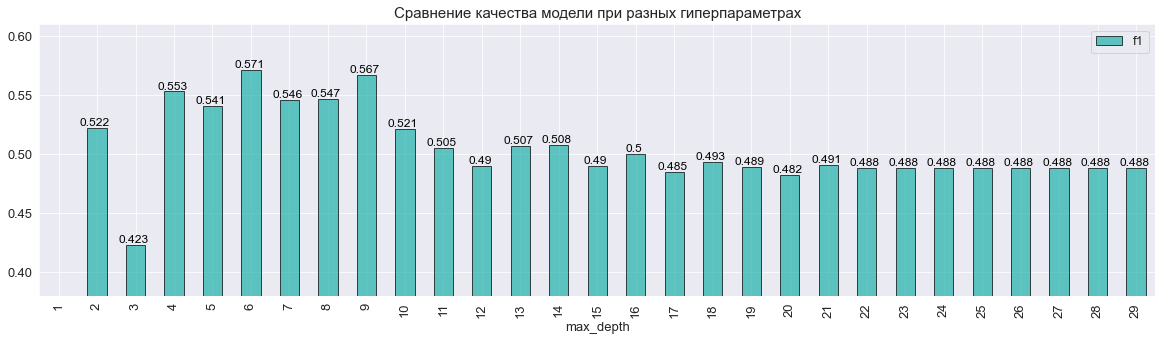

In [29]:
bar_model(tree_df, 'max_depth', 0.38, 0.61)

- наилучшие значения `f1-меры` достигаются при максимально допустимой глубине дерева 4⩽`max_depth`⩽15
- данная модель не обеспечивает требуемое заказчиком значение `f1-меры` ⩾0.59

Сравним значения AUC-ROC с F1-мерой графически.

Создадим функцию `matching_auc_f1`, на вход которой подается:
- `model_df` - датафрейм качества соответствующей модели

In [30]:
def matching_auc_f1(model_df):    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7), gridspec_kw={'width_ratios': [2, 1]})
    
    fig.subplots_adjust(wspace=0.1)
    
    fig.suptitle('Сравнение значения AUC-ROC с F1-мерой', y = 1.0, fontsize = 14)
    
    ax1, ax2 = axes
    ax1.set_title('Диаграмма рассеяния между\nf1-мерой и AUC-ROC', fontsize=13)
    ax2.set_title('Тепловая карта корреляций\nметрик и гиперпараметра модели', fontsize=13)
    
    sns.scatterplot(x='f1', y='AUC-ROC', data=model_df, s=150, alpha=0.7, linewidth=2, ax=ax1)
    sns.heatmap(model_df.corr(), annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g', ax=ax2);

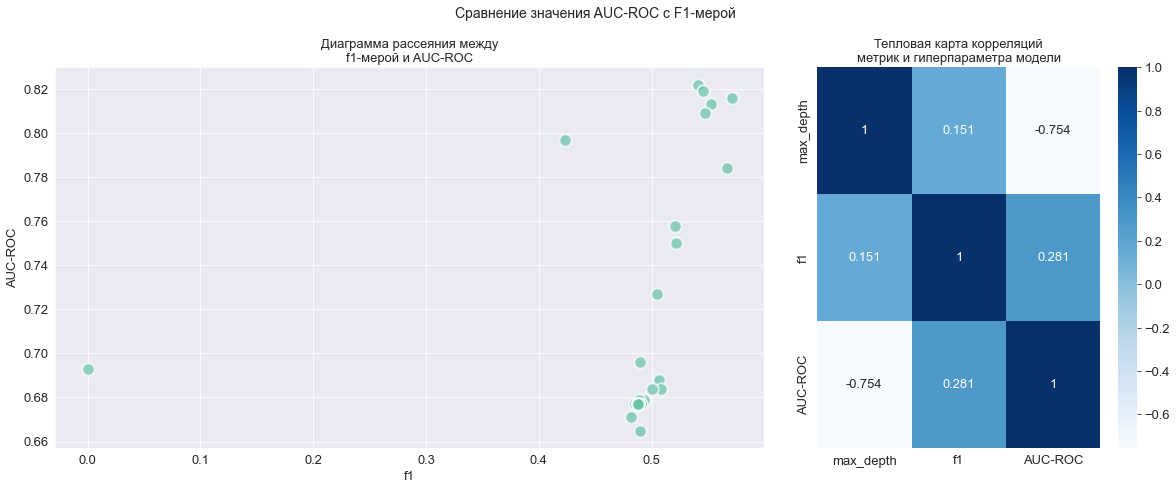

In [31]:
matching_auc_f1(tree_df)

Корреляция между f1 и AUC-ROC положительная, но невысокая.

### Случайный лес

In [32]:
est_range = range(1, 30)
f1_list=[]
auc_list=[]

for est in est_range:
    model = RandomForestClassifier(random_state=12345, n_estimators=est) # создание модели с различными значениями n_estimators
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
    f1_list.append(f1_score(target_valid, predicted_valid).round(3)) # f1-мера
    probabilities_valid = model.predict_proba(features_valid) # функция вычисления вероятности классов
    probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
    auc_list.append(roc_auc_score(target_valid, probabilities_one_valid).round(3)) # AUC-ROC    
    
forest_df = pd.DataFrame({'n_estimators': list(est_range), 'f1':f1_list, 'AUC-ROC':auc_list})
forest_df.sort_values(by='f1', ascending=False).reset_index(drop=True).head(3)

,n_estimators,f1,AUC-ROC
0,29,0.574,0.832
1,25,0.573,0.833
2,23,0.571,0.834


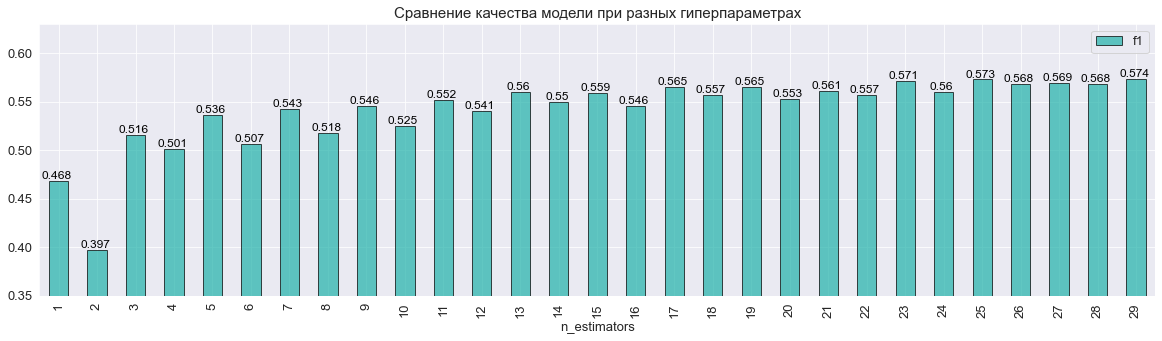

In [33]:
bar_model(forest_df, 'n_estimators', 0.35, 0.63)

- наилучшие значения `f1-меры` достигаются при максимальном числе деревьев `n_estimators`⩾5
- данная модель обеспечивает требуемое заказчиком значение `f1-меры` ⩾0.59

Сравним значения AUC-ROC с F1-мерой графически.

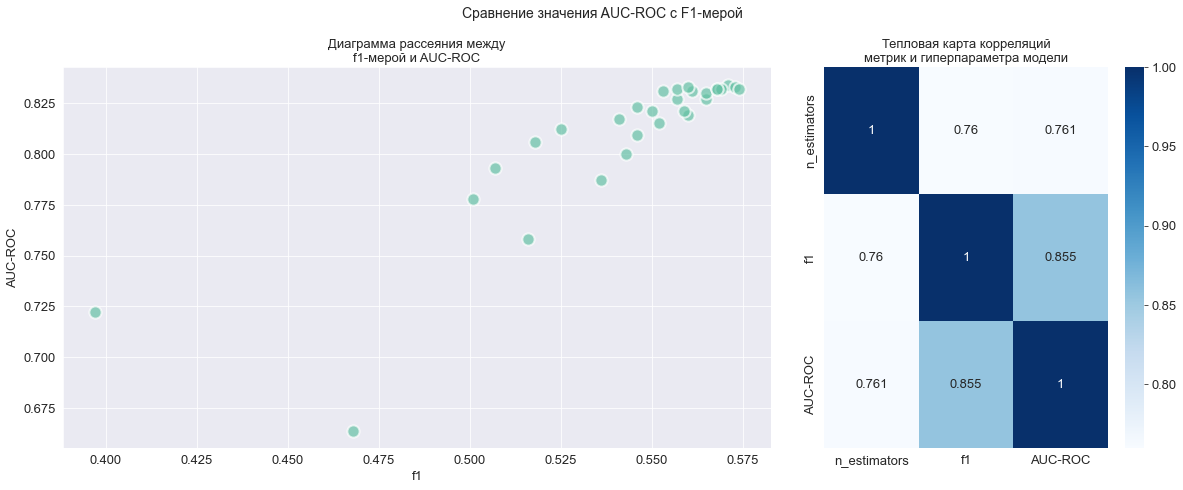

In [34]:
matching_auc_f1(forest_df)

Корреляция между f1 и AUC-ROC положительная и довольно высокая.

### Логистическая регрессия

In [35]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
f1_list=[]
auc_list=[]

for solv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    model = LogisticRegression(random_state=12345, solver=solv, max_iter=1000) # создание модели с различными гиперпараметрами
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
    f1_list.append(f1_score(target_valid, predicted_valid).round(3)) # f1-мера
    probabilities_valid = model.predict_proba(features_valid) # функция вычисления вероятности классов
    probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
    auc_list.append(roc_auc_score(target_valid, probabilities_one_valid).round(3)) # AUC-ROC    

logistic_df = pd.DataFrame({'solver': solvers, 'f1':f1_list, 'AUC-ROC':auc_list})
logistic_df.sort_values(by='f1', ascending=False).reset_index(drop=True)

,solver,f1,AUC-ROC
0,newton-cg,0.334,0.758
1,lbfgs,0.334,0.758
2,liblinear,0.334,0.758
3,sag,0.334,0.758
4,saga,0.334,0.758


- значение `f1-меры` одинаково при любом значении гиперпараметров
- данная модель не обеспечивает требуемое заказчиком значение `f1-меры` ⩾0.59

Значения AUC-ROC и F1-меры постоянны.

### Сравнение результатов

Создадим функции `results_df()` и `corr_df()` для сохранения результатов в будущих шагах.

Функции возвращают датафреймы с лучшим качеством и корреляцией метрик моделей соответственно.

In [36]:
def results_df():
    return pd.DataFrame({'model': ['tree_df','forest_df','logistic_df'],
                                'f1':[tree_df['f1'].max(),forest_df['f1'].max(),logistic_df['f1'].max()]})

In [37]:
def corr_df():    
    return pd.DataFrame({'model': ['tree_df','forest_df'],
                                'corr':[tree_df['f1'].corr(tree_df['AUC-ROC']), forest_df['f1'].corr(forest_df['AUC-ROC'])]})

Запишем лучшие результаты в переменные

In [38]:
best_results_1 = results_df()
metrics_corr_1 = corr_df()

Графическое сравнение результатов

Создадим функцию `matching_results` для графического сравнения результатов.

На вход функции подаётся:
- `best_results` - датафрейм с лучшими результатами качества
- `metrics_corr` - датафрейм со значениями корреляций метрик

In [39]:
def matching_results(best_results, metrics_corr):    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5), gridspec_kw={'width_ratios': [1, 1]})
    
    fig.subplots_adjust(wspace=0.5)
    
    fig.suptitle('Сравнение результатов', y = 1.18, fontsize = 14)
    
    ax1, ax2 = axes
    ax1.set_title('Тепловая карта\nкачества моделей', fontsize=13, y = 1.02)
    ax2.set_title('Сравнение корреляций\nметрик f1 и AUC моделей', fontsize=13, y = 1.02)
    
    sns.heatmap(best_results.set_index('model').sort_values(by='f1', ascending=False),
                annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g', ax=ax1)
    
    sns.heatmap(metrics_corr.set_index('model').sort_values(by='corr', ascending=False),
                annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g', ax=ax2);

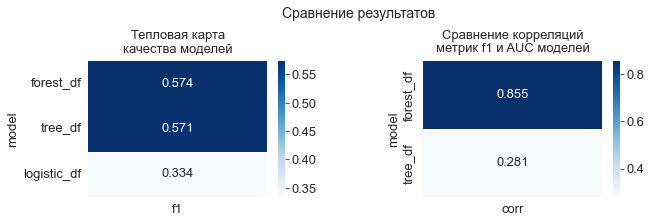

In [40]:
matching_results(best_results_1, metrics_corr_1) 

Вывод.
- наилучшие результаты показала модель **случайный лес**, на втором месте - **дерево решений**, на третьем - **логистическая регрессия**
- модель **случайный лес** обеспечивает требуемое заказчиком значение `f1-меры`⩾0.59, остальные нет
- корреляция между f1 и AUC-ROC:
    - для  **дерева решений** положительная, но невысокая
    - для **случайного леса** положительная и довольно высокая
    - для **логистической регрессии** значения AUC-ROC и F1-меры постоянны

## Обучение модели с учётом дисбаланса

Поработаем над улучшением качества модели.

### Увеличение веса редкого класса

Придадим объектам редкого класса бóльший вес, применив значение аргумента `class_weight='balanced'`.

#### Дерево решений

In [41]:
depth_range = range(1, 30)
f1_list=[]
auc_list=[]

for depth in depth_range:
    model = DecisionTreeClassifier(random_state=12345,
                                   max_depth=depth,
                                   class_weight='balanced') # создание модели с различными значениями max_depth
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
    f1_list.append(f1_score(target_valid, predicted_valid).round(3)) # f1-мера
    probabilities_valid = model.predict_proba(features_valid) # функция вычисления вероятности классов
    probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
    auc_list.append(roc_auc_score(target_valid, probabilities_one_valid).round(3)) # AUC-ROC    
    
    
tree_df = pd.DataFrame({'max_depth': list(depth_range), 'f1':f1_list, 'AUC-ROC':auc_list})
tree_df.sort_values(by='f1', ascending=False).reset_index(drop=True).head(3)

,max_depth,f1,AUC-ROC
0,5,0.596,0.831
1,6,0.556,0.798
2,7,0.546,0.784


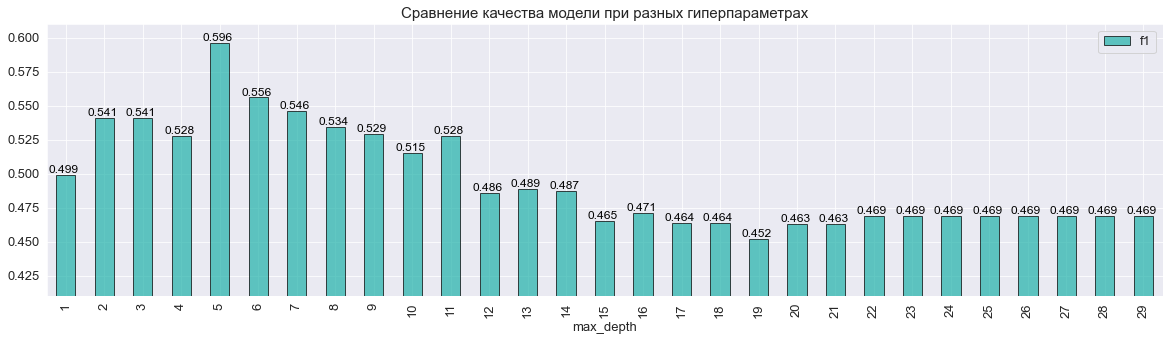

In [42]:
bar_model(tree_df, 'max_depth', 0.41, 0.61)

- `f1-мера` увеличилась
- обеспечено требуемое заказчиком значение `f1-меры`⩾0.59

Сравним значения AUC-ROC с F1-мерой графически.

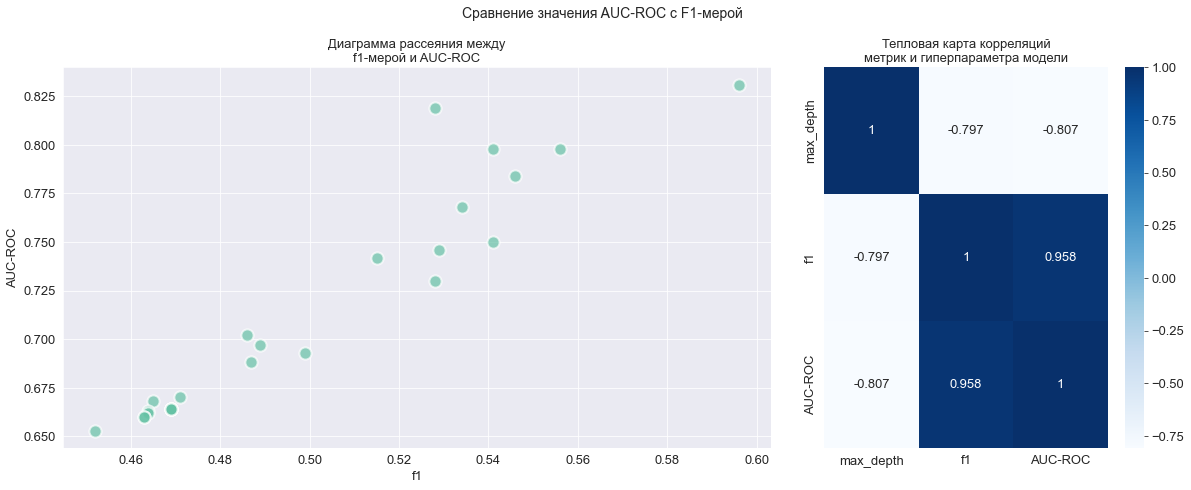

In [43]:
matching_auc_f1(tree_df)

Корреляция между f1 и AUC-ROC положительная и довольно высокая.

#### Случайный лес

In [44]:
est_range = range(1, 30)
f1_list=[]
auc_list=[]

for est in est_range:
    model = RandomForestClassifier(random_state=12345,
                                   n_estimators=est,
                                   class_weight='balanced') # создание модели с различными значениями n_estimators
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
    f1_list.append(f1_score(target_valid, predicted_valid).round(3)) # f1-мера 
    probabilities_valid = model.predict_proba(features_valid) # функция вычисления вероятности классов
    probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
    auc_list.append(roc_auc_score(target_valid, probabilities_one_valid).round(3)) # AUC-ROC  
    
forest_df = pd.DataFrame({'n_estimators': list(est_range), 'f1':f1_list, 'AUC-ROC':auc_list})
forest_df.sort_values(by='f1', ascending=False).reset_index(drop=True).head(3)

,n_estimators,f1,AUC-ROC
0,13,0.573,0.824
1,9,0.571,0.818
2,23,0.571,0.833


- `f1-мера` уменьшилась.
- не обеспечено требуемое заказчиком значение `f1-меры`⩾0.59

Попробуем дополнительно подобрать гиперпараметры при помощи модуля `GridSearchCV`

In [45]:
%%time

f1 = make_scorer(f1_score, average='weighted')
forest_better = RandomForestClassifier(random_state=12345, class_weight='balanced')
parametrs = {'n_estimators': list(range(11,31)),
             'max_depth': list(range(4,10))}
grid = GridSearchCV(forest_better, parametrs, cv=3, scoring=f1)
grid.fit(features_train, target_train)
print(f'Лучшее значение max_depth: {grid.best_params_.get("max_depth")}')

Лучшее значение max_depth: 9
CPU times: total: 28.3 s
Wall time: 28.3 s


In [46]:
est_range = range(1, 30)
f1_list=[]
auc_list=[]

for est in est_range:
    model = RandomForestClassifier(random_state=12345,
                                   n_estimators=est,
                                   class_weight='balanced',
                                   max_depth=9) # создание модели с различными значениями n_estimators
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
    f1_list.append(f1_score(target_valid, predicted_valid).round(3)) # f1-мера    
    probabilities_valid = model.predict_proba(features_valid) # функция вычисления вероятности классов
    probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
    auc_list.append(roc_auc_score(target_valid, probabilities_one_valid).round(3)) # AUC-ROC

forest_df = pd.DataFrame({'n_estimators': list(est_range), 'f1':f1_list, 'AUC-ROC':auc_list})
forest_df.sort_values(by='f1', ascending=False).reset_index(drop=True).head(3)

,n_estimators,f1,AUC-ROC
0,27,0.627,0.849
1,17,0.625,0.845
2,29,0.621,0.849


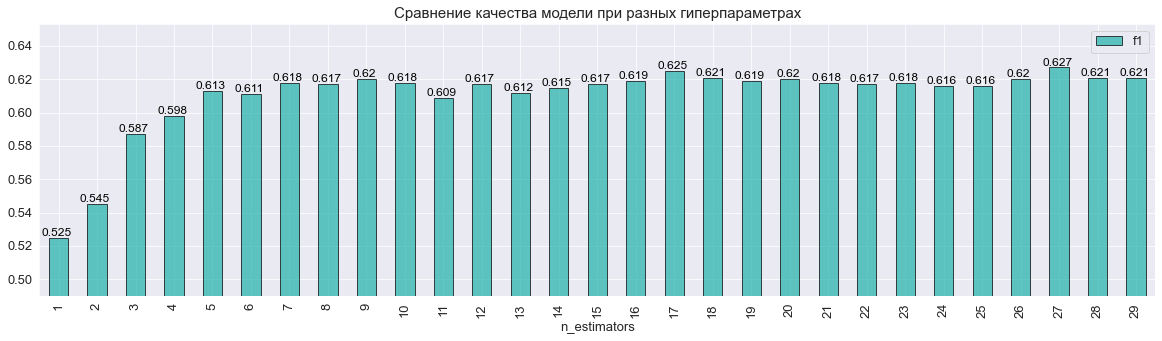

In [47]:
bar_model(forest_df, 'n_estimators', 0.49, 0.653)

- найдены более оптимальные гиперпараметры
- обеспечено требуемое заказчиком значение `f1-меры`⩾0.59

Сравним значения AUC-ROC с F1-мерой графически.

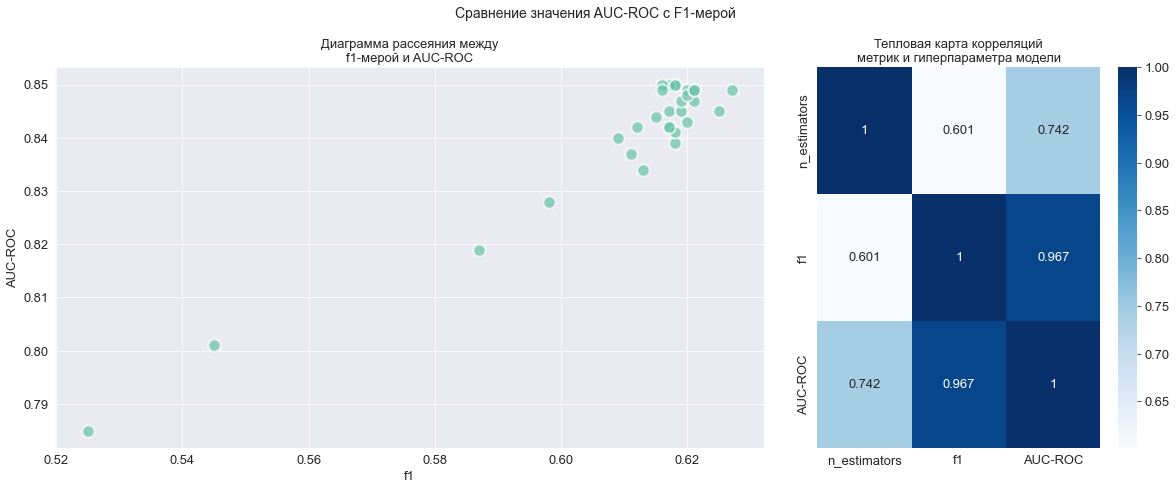

In [48]:
matching_auc_f1(forest_df)

Корреляция между f1 и AUC-ROC положительная и довольно высокая.

#### Логистическая регрессия

In [49]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
f1_list=[]
auc_list=[]

for solv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    model = LogisticRegression(random_state=12345,
                               solver=solv,
                               max_iter=1000,
                               class_weight='balanced') # создание модели с различными гиперпараметрами
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
    f1_list.append(f1_score(target_valid, predicted_valid).round(3)) # f1-мера 
    probabilities_valid = model.predict_proba(features_valid) # функция вычисления вероятности классов
    probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
    auc_list.append(roc_auc_score(target_valid, probabilities_one_valid).round(3)) # AUC-ROC

logistic_df = pd.DataFrame({'solver': solvers, 'f1':f1_list, 'AUC-ROC':auc_list})
logistic_df.sort_values(by='f1', ascending=False).reset_index(drop=True)

,solver,f1,AUC-ROC
0,newton-cg,0.487,0.763
1,lbfgs,0.487,0.763
2,liblinear,0.487,0.763
3,sag,0.487,0.763
4,saga,0.487,0.763


- значение `f1-меры` одинаково при любом значении гиперпараметров
- данная модель не обеспечивает требуемое заказчиком значение `f1-меры` ⩾0.59

Значения AUC-ROC и F1-меры постоянны.

#### Сравнение результатов

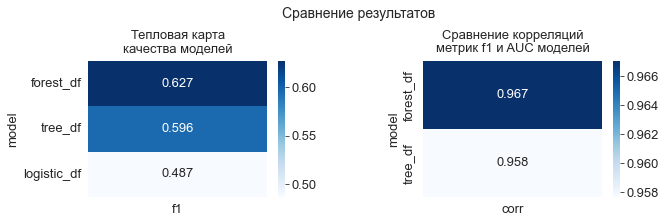

In [50]:
best_results_2 = results_df()
metrics_corr_2 = corr_df()
matching_results(best_results_2, metrics_corr_2) 

Вывод.
- качество при увеличении веса редкого класса улучшилось
- наилучшие результаты показала модель **случайный лес**, на втором месте - **дерево решений**, на третьем - **логистическая регрессия**
- модели **случайный лес** и **дерево решений** обеспечивают требуемое заказчиком значение `f1-меры`⩾0.59.
- корреляция между f1 и AUC-ROC:
    - для **случайного леса** и **дерева решений** положительная и довольно высокая
    - для **логистической регрессии** значения AUC-ROC и F1-меры постоянны

### Увеличение выборки (upsampling)

#### Создание функции upsample

Сделаем объекты редкого класса не такими редкими в данных.

Для этого создадим функцию `upsample()` с тремя параметрами:
- `features` — признаки,
- `target` — целевой признак,
- `repeat` — количество повторений.

Принцип работы функции.

Разделим обучающую выборку на отрицательные и положительные объекты:
- features_zeros — признаки объектов с ответом «0»;
- features_ones — признаки объектов с ответом «1»;
- target_zeros — целевой признак объектов, у которых ответы только «0»;
- target_ones — целевой признак объектов, у которых ответы только «1».

Продублируем объекты положительного класса и объединим их с объектами отрицательного класса.

Объединим таблицы с признаками и сохраним результат в переменной `features_upsampled` (признаки, преобразованные техникой upsampling).

Объединим таблицы с целевым признаком и сохраним результат в переменной `target_upsampled` (целевой признак, преобразованный техникой upsampling).

Перемешаем данные при помощи функции функцию shuffle().

Функция вернёт признаки и целевой признак после операции upsampling.

In [51]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled,
                                                   target_upsampled,
                                                   random_state=12345)    
    return features_upsampled, target_upsampled

Далее обучим на новых данных различные модели, подобрав оптимальное значение количества повторений `repeat`.

#### Дерево решений

Создадим функцию `tree_func()` для сравнения результатов с параметрами:
- `sample_method` - метод выборки (*upsample* или *downsample*)
- `parametr` - изменяемый параметр (*repeat* (кол-во повторений) или *fraction* (доля))

На выходе функции - датафрейм с результатами обученной модели:
- `max_depth` - максимальная глубина дерева
- `f1` - f1-мера

In [52]:
def tree_func(sample_method, parametr):
    features_sampled, target_sampled = sample_method(features_train, target_train, parametr)
    depth_range = range(1, 30)
    f1_list=[]
    auc_list=[]
    
    for depth in depth_range:
        model = DecisionTreeClassifier(random_state=12345,
                                       max_depth=depth) # создание модели с различными значениями max_depth
        model.fit(features_sampled, target_sampled) # обучение модели на тренировочной выборке
        predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
        f1_list.append(f1_score(target_valid, predicted_valid).round(3)) # f1-мера
        probabilities_valid = model.predict_proba(features_valid) # функция вычисления вероятности классов
        probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
        auc_list.append(roc_auc_score(target_valid, probabilities_one_valid).round(3)) # AUC-ROC        
        
    return pd.DataFrame({'max_depth': list(depth_range), 'f1':f1_list, 'AUC-ROC':auc_list})    

Создадим три различных датафрейма для сравнения результатов обученных моделей при различном количестве повторений

In [53]:
model_list = ['tree_df_1', 'tree_df_2', 'tree_df_3']
repeat_list = [3, 4, 5]
for i in range(3):    
    locals()[model_list[i]] = tree_func(upsample, repeat_list[i])

Выведем на экран лучшие результаты f1-меры для каждой модели

In [54]:
best_tree_repeat=(pd.merge(tree_df_1.sort_values(by='f1', ascending=False).reset_index(drop=True),
                  pd.merge(tree_df_2.sort_values(by='f1', ascending=False).reset_index(drop=True),
                           tree_df_3.sort_values(by='f1', ascending=False).reset_index(drop=True),
                           left_index=True, right_index=True, suffixes=['_2','_3']),
                  left_index=True, right_index=True)
                  .rename(columns={'max_depth':'max_depth_1','f1':'f1_1', 'AUC-ROC':'AUC-ROC_1'}))
best_tree_repeat.head(3)

,max_depth_1,f1_1,AUC-ROC_1,max_depth_2,f1_2,AUC-ROC_2,max_depth_3,f1_3,AUC-ROC_3
0,5,0.586,0.823,5,0.596,0.831,3,0.558,0.799
1,6,0.578,0.818,6,0.556,0.798,2,0.541,0.750
2,8,0.565,0.790,7,0.549,0.789,5,0.538,0.828


Для наглядности отобразим результаты графически в виде трех столбчатых диаграмм в одних осях

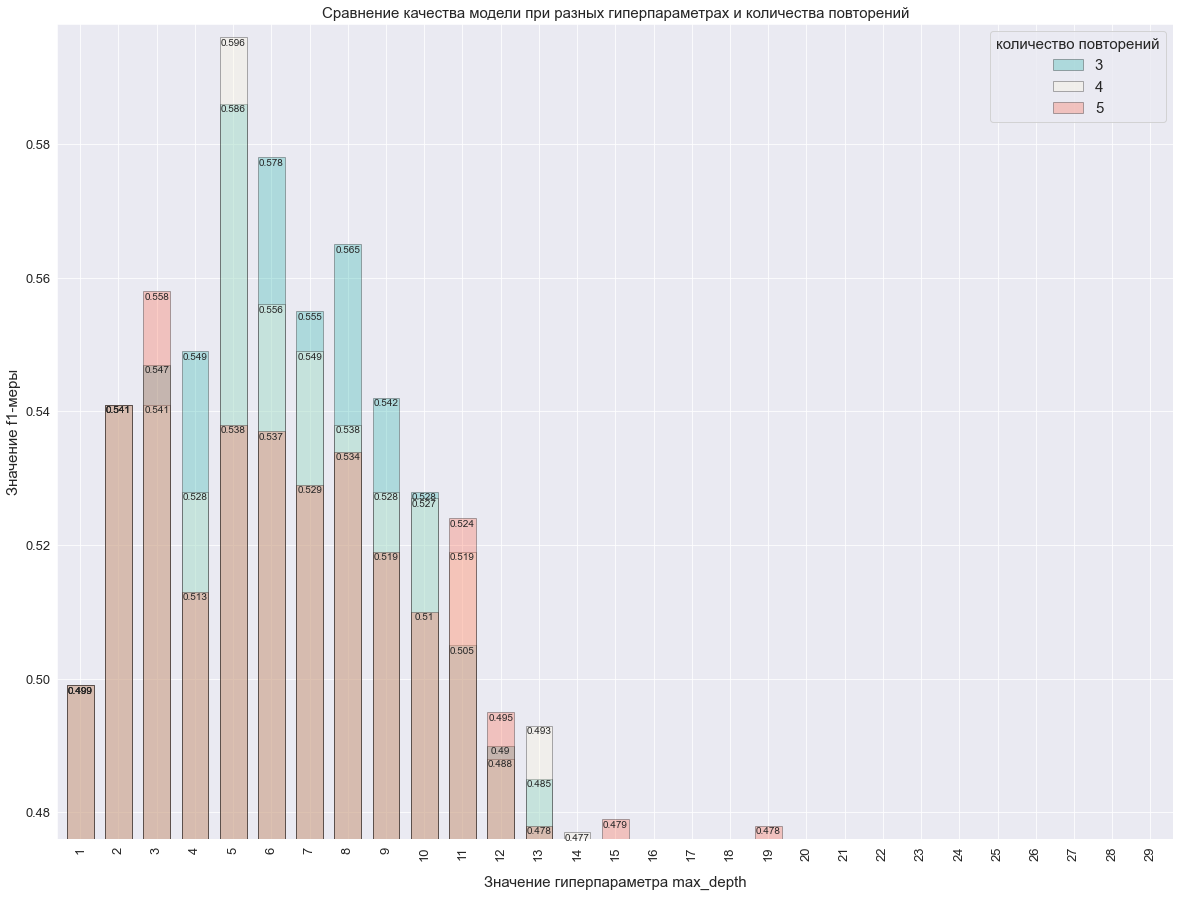

In [55]:
x_param='max_depth'

colors = ['lightseagreen', 'cornsilk', 'tomato']
plots = ['plot_1','plot_2', 'plot_3']
paddings = [-10, -10, -10]
plt.title('Сравнение качества модели при разных гиперпараметрах и количества повторений', fontsize=15)

for i in range(3):
    ax = plt.gca()
    locals()[plots[i]]=locals()[model_list[i]].plot(kind='bar',
                                                   x=x_param,
                                                   y='f1',
                                                   figsize=(20,15),
                                                   ec='black',
                                                   ax=ax,
                                                   width=0.7,
                                                   color=colors[i],
                                                   fontsize=13,
                                                   alpha=0.3,
                                                   ylim=(0.476, 0.598))
    locals()[plots[i]].bar_label(ax.containers[i], padding=paddings[i], fontsize=10)
    locals()[plots[i]].legend(repeat_list,fontsize=15, title='количество повторений', title_fontsize=15)

plt.xlabel(f'Значение гиперпараметра {x_param}', fontsize= 15, labelpad = 15)    
plt.ylabel('Значение f1-меры', fontsize=15);

- `f1-мера` при лучших гиперпараметре и числе повторений аналогична модели с увеличенным весом редкого класса
- обеспечено требуемое заказчиком значение `f1-меры`⩾0.59
- самый лучший результат при количестве повторений 4, однако чаще лучшие результаты наблюдались при количестве повторений 3.

Присвоим переменной `tree_df` результаты лучшей модели для сравнения результатов текущей техники

In [56]:
tree_df = tree_df_2

Сравним значения AUC-ROC с F1-мерой графически.

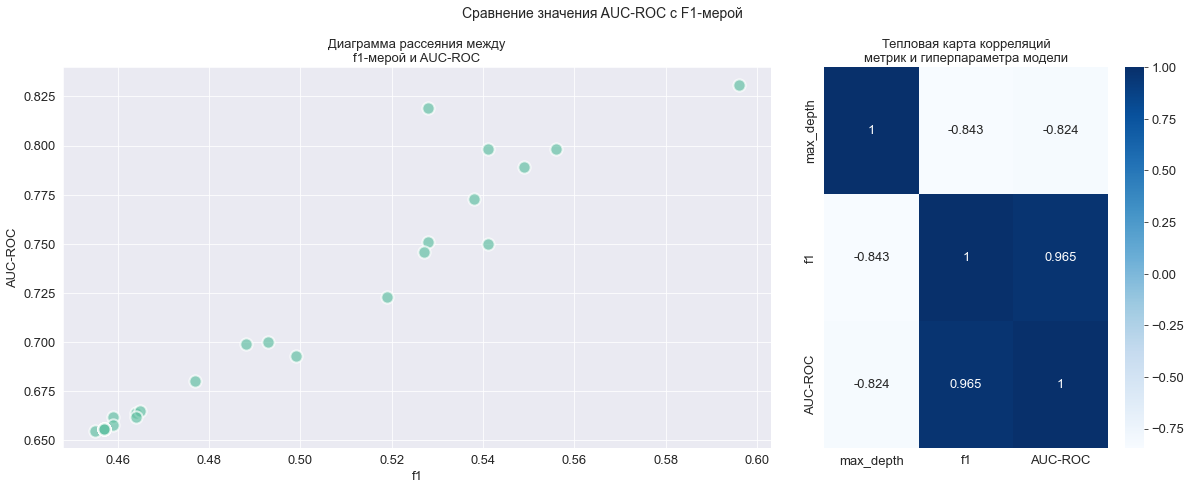

In [57]:
matching_auc_f1(tree_df)

Корреляция между f1 и AUC-ROC положительная и довольно высокая.

#### Случайный лес

Создадим функцию `forest_func()` для сравнения результатов с параметрами:
- `sample_method` - метод выборки (*upsample* или *downsample*)
- `parametr` - изменяемый параметр (*repeat* (кол-во повторений) или *fraction* (доля))

На выходе функции - датафрейм с результатами обученной модели:
- `n_estimators` - количество деревьев
- `f1` - f1-мера

In [58]:
def forest_func(sample_method, parametr):
    features_sampled, target_sampled = sample_method(features_train, target_train, parametr)
    est_range = range(1, 30)
    f1_list=[]
    auc_list=[]
    
    for est in est_range:
        model = RandomForestClassifier(random_state=12345,
                                       max_depth=9,
                                       n_estimators=est) # создание модели с различными значениями n_estimators
        model.fit(features_sampled, target_sampled) # обучение модели на тренировочной выборке
        predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
        f1_list.append(f1_score(target_valid, predicted_valid).round(3)) # f1-мера 
        probabilities_valid = model.predict_proba(features_valid) # функция вычисления вероятности классов
        probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
        auc_list.append(roc_auc_score(target_valid, probabilities_one_valid).round(3)) # AUC-ROC
        
    return pd.DataFrame({'n_estimators': list(depth_range), 'f1':f1_list, 'AUC-ROC':auc_list})    

Создадим три различных датафрейма для сравнения результатов обученных моделей при различном количестве повторений

In [59]:
model_list = ['forest_df_1', 'forest_df_2', 'forest_df_3']
repeat_list = [3, 4, 5]
for i in range(3):    
    locals()[model_list[i]] = forest_func(upsample, repeat_list[i])

Выведем на экран лучшие результаты f1-меры для каждой модели

In [60]:
best_forest_repeat=(pd.merge(forest_df_1.sort_values(by='f1', ascending=False).reset_index(drop=True),
                    pd.merge(forest_df_2.sort_values(by='f1', ascending=False).reset_index(drop=True),
                             forest_df_3.sort_values(by='f1', ascending=False).reset_index(drop=True),
                             left_index=True, right_index=True, suffixes=['_2','_3']),
                             left_index=True, right_index=True)
                    .rename(columns={'n_estimators':'n_estimators_1','f1':'f1_1', 'AUC-ROC':'AUC-ROC_1'}))
best_forest_repeat.head(3)

,n_estimators_1,f1_1,AUC-ROC_1,n_estimators_2,f1_2,AUC-ROC_2,n_estimators_3,f1_3,AUC-ROC_3
0,24,0.620,0.846,26,0.627,0.849,15,0.612,0.842
1,26,0.616,0.846,27,0.626,0.851,16,0.609,0.843
2,25,0.616,0.846,29,0.625,0.851,23,0.606,0.847


Для наглядности отобразим результаты графически в виде трех столбчатых диаграмм в одних осях

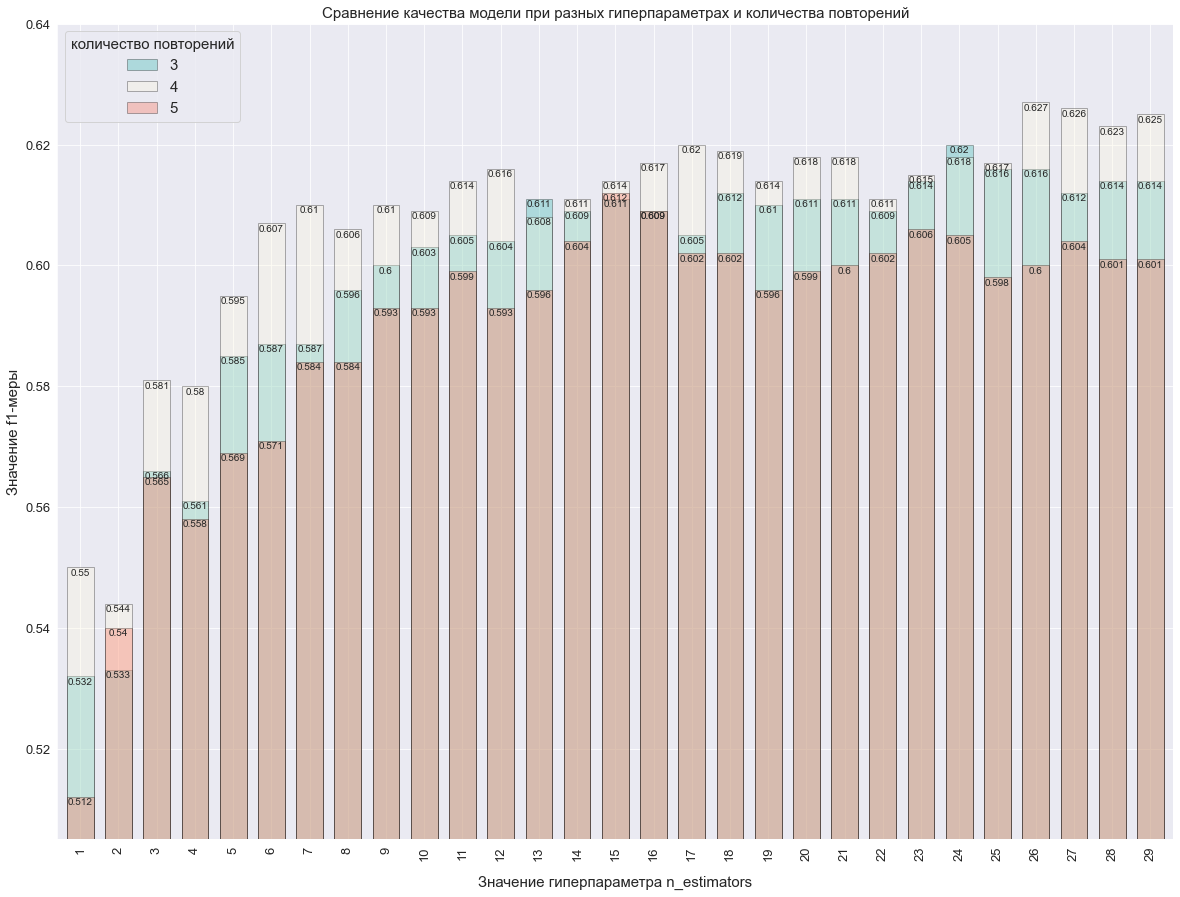

In [61]:
x_param='n_estimators'

colors = ['lightseagreen', 'cornsilk', 'tomato']
plots = ['plot_1','plot_2', 'plot_3']
paddings = [-10, -10, -10]
plt.title('Сравнение качества модели при разных гиперпараметрах и количества повторений', fontsize=15)

for i in range(3):
    ax = plt.gca()
    locals()[plots[i]]=locals()[model_list[i]].plot(kind='bar',
                                                   x=x_param,
                                                   y='f1',
                                                   figsize=(20,15),
                                                   ec='black',
                                                   ax=ax,
                                                   width=0.7,
                                                   color=colors[i],
                                                   fontsize=13,
                                                   alpha=0.3,
                                                   ylim=(0.505, 0.640))
    locals()[plots[i]].bar_label(ax.containers[i], padding=paddings[i], fontsize=10)
    locals()[plots[i]].legend(repeat_list,fontsize=15, title='количество повторений', title_fontsize=15)

plt.xlabel(f'Значение гиперпараметра {x_param}', fontsize= 15, labelpad = 15)    
plt.ylabel('Значение f1-меры', fontsize=15);

- `f1-мера` при лучших гиперпараметре и числе повторений увеличилась относительно модели с увеличенным весом редкого класса
- обеспечено требуемое заказчиком значение `f1-меры`⩾0.59
- лучшие результаты при количестве повторений 4.

Проверим, удастся ли подобрать лучшие гиперпараметры при помощи модуля `RandomizedSearchCV`

In [62]:
%%time

f1 = make_scorer(f1_score, average='weighted')
forest_better = RandomForestClassifier(random_state=12345)
parametrs = {'n_estimators': list(range(11,61)),
             'max_depth': list(range(2,60))}
clf = RandomizedSearchCV(forest_better, parametrs, cv=3, scoring=f1, random_state=12345)
clf.fit(features_train, target_train)

CPU times: total: 5.52 s
Wall time: 5.57 s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, 31, ...],
                                        'n_estimators': [11, 12, 13, 14, 15, 16,
                                                         17, 18, 19, 20, 21, 22,
                                                         23, 24, 25, 26, 27, 28,
                                                         29, 30, 31, 32, 33, 34,
                                                         35, 36, 37, 38, 39, 40, ...]},
                   random_state=12345,
                   scoring=make_scorer(f1_score, average=weighted))

In [63]:
print(f'Лучшие параметры: {clf.best_params_}')

Лучшие параметры: {'n_estimators': 43, 'max_depth': 19}


Посмотрим на результаты при фиксированном значении `max_depth`, полученном при помощи модуля `RandomizedSearchCV`, и различных `n_estimators`.

In [64]:
est_range = range(20, 50)
f1_list=[]
auc_list=[]

for est in est_range:
    model = RandomForestClassifier(random_state=12345,
                                   n_estimators=est,
                                   max_depth=11) # создание модели с различными значениями n_estimators
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
    f1_list.append(f1_score(target_valid, predicted_valid).round(3)) # f1-мера
    probabilities_valid = model.predict_proba(features_valid) # функция вычисления вероятности классов
    probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
    auc_list.append(roc_auc_score(target_valid, probabilities_one_valid).round(3)) # AUC-ROC    
    
forest_df = pd.DataFrame({'n_estimators': list(est_range), 'f1':f1_list, 'AUC-ROC':auc_list})
forest_df.sort_values(by='f1', ascending=False).reset_index(drop=True).head(3)

,n_estimators,f1,AUC-ROC
0,42,0.584,0.842
1,44,0.581,0.842
2,43,0.581,0.841


Результаты уступают ранее полученной модели

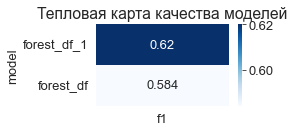

In [65]:
best_results = pd.DataFrame({'model': ['forest_df','forest_df_1'],
                            'f1':[forest_df['f1'].max(),forest_df_1['f1'].max()]})
plt.figure(figsize=(3,1.5))
plt.title('Тепловая карта качества моделей')
sns.heatmap(best_results.set_index('model').sort_values(by='f1', ascending=False),
            annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g');

Присвоим переменной `forest_df` результаты лучшей модели для сравнения результатов текущей техники

In [66]:
forest_df = forest_df_1

Сравним значения AUC-ROC с F1-мерой графически

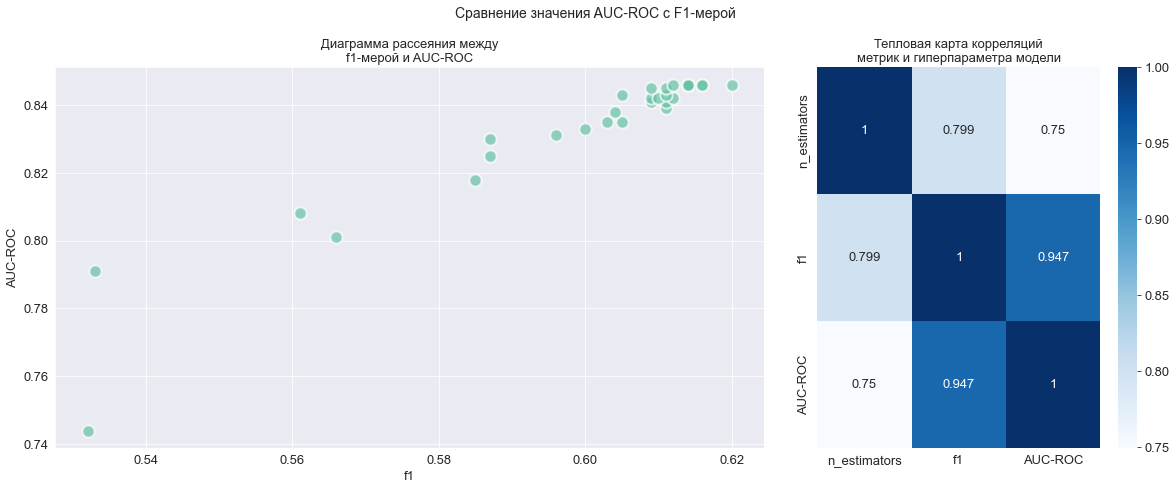

In [67]:
matching_auc_f1(forest_df)

Корреляция между f1 и AUC-ROC положительная и довольно высокая.

#### Логистическая регрессия

Создадим функцию `logistic_func()` для сравнения результатов с параметрами:
- `sample_method` - метод выборки (*upsample* или *downsample*)
- `parametr` - изменяемый параметр (*repeat* (кол-во повторений) или *fraction* (доля))

На выходе функции - датафрейм с результатами обученной модели:
- `solver` - гиперпараметр, позволяющий выбрать алгоритм, который будет строить модель
- `f1` - f1-мера

In [68]:
def logistic_func(sample_method, parametr):
    features_sampled, target_sampled = sample_method(features_train, target_train, parametr)
    solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    f1_list=[]
    auc_list=[]
    
    for solv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        model = LogisticRegression(random_state=12345,
                                   solver=solv,
                                   max_iter=1000) # создание модели с различными гиперпараметрами
        model.fit(features_sampled, target_sampled) # обучение модели на тренировочной выборке
        predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
        f1_list.append(f1_score(target_valid, predicted_valid).round(3)) # f1-мера
        probabilities_valid = model.predict_proba(features_valid) # функция вычисления вероятности классов
        probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
        auc_list.append(roc_auc_score(target_valid, probabilities_one_valid).round(3)) # AUC-ROC
    return pd.DataFrame({'solver': solvers, 'f1':f1_list, 'AUC-ROC':auc_list})  

Создадим три различных датафрейма для сравнения результатов обученных моделей при различном количестве повторений

In [69]:
model_list = ['logistic_df_1', 'logistic_df_2', 'logistic_df_3']
repeat_list = [3, 4, 5]
for i in range(3):    
    locals()[model_list[i]] = logistic_func(upsample, repeat_list[i])

Выведем на экран лучшие результаты f1-меры для каждой модели

In [70]:
best_logistic_repeat=(pd.merge(logistic_df_1.sort_values(by='f1', ascending=False).reset_index(drop=True),
                    pd.merge(logistic_df_2.sort_values(by='f1', ascending=False).reset_index(drop=True),
                             logistic_df_3.sort_values(by='f1', ascending=False).reset_index(drop=True),
                             left_index=True, right_index=True, suffixes=['_2','_3']),
                             left_index=True, right_index=True)
                    .rename(columns={'solver':'solver_1','f1':'f1_1', 'AUC-ROC':'AUC-ROC_1'}))
best_logistic_repeat.head(3)

,solver_1,f1_1,AUC-ROC_1,solver_2,f1_2,AUC-ROC_2,solver_3,f1_3,AUC-ROC_3
0,newton-cg,0.499,0.762,newton-cg,0.487,0.763,newton-cg,0.488,0.764
1,lbfgs,0.499,0.762,lbfgs,0.487,0.763,lbfgs,0.488,0.764
2,liblinear,0.499,0.762,liblinear,0.487,0.763,liblinear,0.488,0.764


- значение `f1-меры` одинаково при любом значении гиперпараметров
- значение `f1-меры` чуть выше, чем у предыдущей модели логистической регрессии
- лучшая модель при количестве повторений 3
- данная модель не обеспечивает требуемое заказчиком значение `f1-меры` ⩾0.59

Присвоим переменной `logistic_df` результаты лучшей модели для сравнения результатов текущей техники

In [71]:
logistic_df = logistic_df_1

#### Сравнение результатов

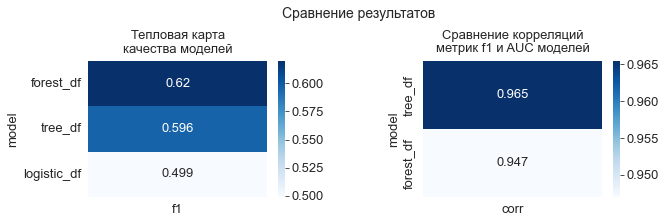

In [72]:
best_results_3 = results_df()
metrics_corr_3 = corr_df()
matching_results(best_results_3, metrics_corr_3) 

Вывод.
- качество при увеличении выборки изменилось незначительно
- наилучшие результаты показала модель **случайный лес**, на втором месте - **дерево решений**, на третьем - **логистическая регрессия**
- модели **случайный лес** и **дерево решений** обеспечивают требуемое заказчиком значение `f1-меры`⩾0.59
- корреляция между f1 и AUC-ROC:
    - для **случайного леса** и **дерева решений** положительная и довольно высокая
    - для **логистической регрессии** значения AUC-ROC и F1-меры постоянны

### Уменьшение выборки (downsampling )

#### Создание функции downsample

Сделаем объекты частого класса не такими частыми в данных.

Для этого создадим функцию `downsample()` с тремя параметрами:
- `features` — признаки,
- `target` — целевой признак,
- `fraction` — доля отрицательных объектов, которые нужно сохранить.

Принцип работы функции.

Разделим обучающую выборку на отрицательные и положительные объекты:
- features_zeros — признаки объектов с ответом «0»;
- features_ones — признаки объектов с ответом «1»;
- target_zeros — целевой признак объектов, у которых ответы только «0»;
- target_ones — целевой признак объектов, у которых ответы только «1».

Случайным образом отбросим часть из отрицательных объектов при помощи функции `sample()`. На вход она принимает аргумент `frac` (от англ. fraction, «доля»). Возвращает случайные элементы в таком количестве, чтобы их доля от исходной таблицы была равна `frac`.

Перемешаем данные при помощи функции функцию shuffle().

Функция вернёт признаки и целевой признак после операции sampling.

In [73]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled,
                                                       target_downsampled,
                                                       random_state=12345)
    
    return features_downsampled, target_downsampled

Далее обучим на новых данных различные модели, подобрав оптимальное значение параметра `fraction`.

#### Дерево решений

Создадим три различных датафрейма для сравнения результатов обученных моделей при различных долях

In [74]:
model_list = ['tree_df_1', 'tree_df_2', 'tree_df_3']
fraction_list = [0.25, 0.35, 0.45]
for i in range(3):    
    locals()[model_list[i]] = tree_func(downsample, fraction_list[i])

Выведем на экран лучшие результаты f1-меры для каждой модели

In [75]:
best_tree_fraction=(pd.merge(tree_df_1.sort_values(by='f1', ascending=False).reset_index(drop=True),
                    pd.merge(tree_df_2.sort_values(by='f1', ascending=False).reset_index(drop=True),
                             tree_df_3.sort_values(by='f1', ascending=False).reset_index(drop=True),
                             left_index=True, right_index=True, suffixes=['_2','_3']),
                             left_index=True, right_index=True)
                    .rename(columns={'max_depth':'max_depth_1','f1':'f1_1', 'AUC-ROC':'AUC-ROC_1'}))
best_tree_fraction.head(3)

,max_depth_1,f1_1,AUC-ROC_1,max_depth_2,f1_2,AUC-ROC_2,max_depth_3,f1_3,AUC-ROC_3
0,5,0.593,0.823,6,0.564,0.811,6,0.573,0.812
1,6,0.574,0.815,3,0.558,0.799,7,0.568,0.809
2,3,0.556,0.803,5,0.546,0.805,4,0.561,0.806


Для наглядности отобразим результаты графически в виде трех столбчатых диаграмм в одних осях

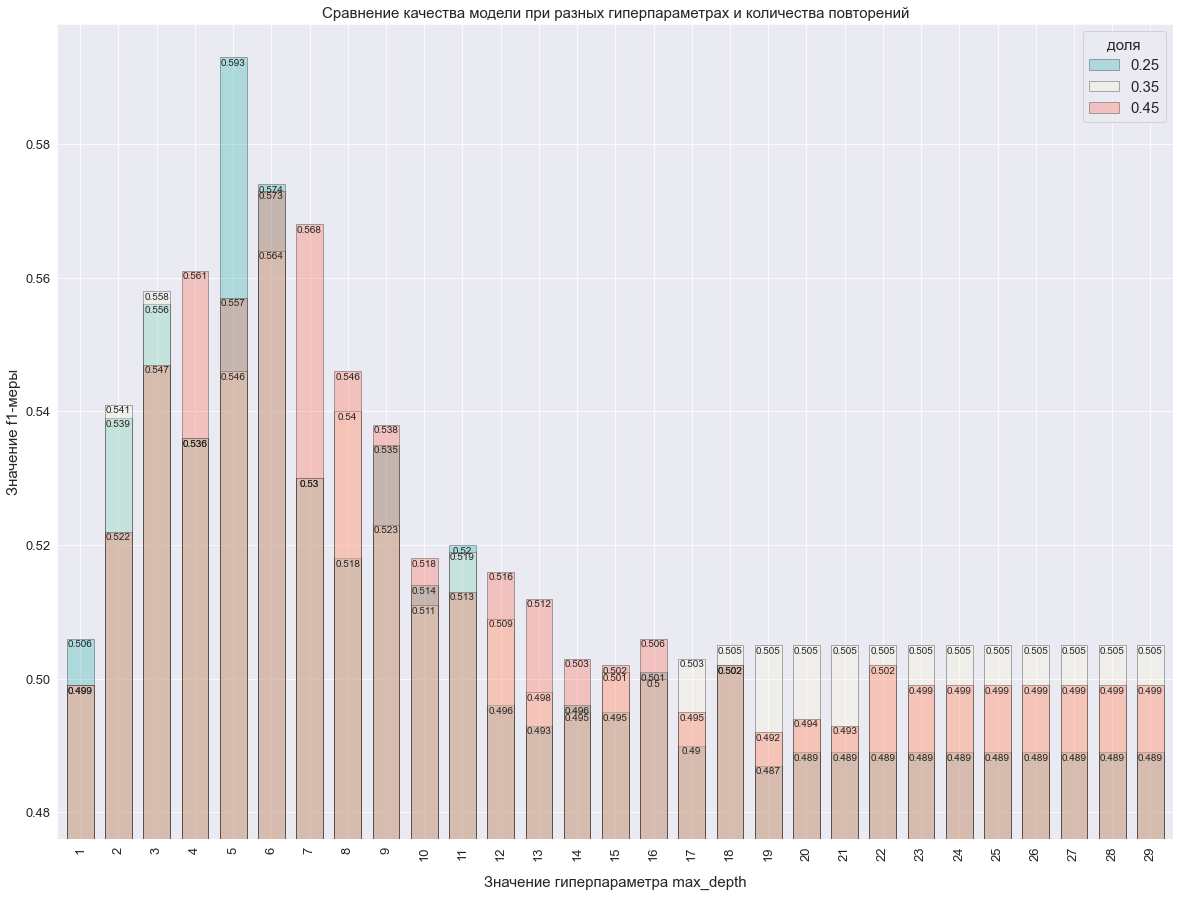

In [76]:
x_param='max_depth'

colors = ['lightseagreen', 'cornsilk', 'tomato']
plots = ['plot_1','plot_2', 'plot_3']
paddings = [-10, -10, -10]
plt.title('Сравнение качества модели при разных гиперпараметрах и количества повторений', fontsize=15)

for i in range(3):
    ax = plt.gca()
    locals()[plots[i]]=locals()[model_list[i]].plot(kind='bar',
                                                   x=x_param,
                                                   y='f1',
                                                   figsize=(20,15),
                                                   ec='black',
                                                   ax=ax,
                                                   width=0.7,
                                                   color=colors[i],
                                                   fontsize=13,
                                                   alpha=0.3,
                                                   ylim=(0.476, 0.598))
    locals()[plots[i]].bar_label(ax.containers[i], padding=paddings[i], fontsize=10)
    locals()[plots[i]].legend(fraction_list,fontsize=15, title='доля', title_fontsize=15)

plt.xlabel(f'Значение гиперпараметра {x_param}', fontsize= 15, labelpad = 15)    
plt.ylabel('Значение f1-меры', fontsize=15);

- `f1-мера` при лучших гиперпараметре и доле аналогична модели, полученной техникой upsampling 
- обеспечено требуемое заказчиком значение `f1-меры`⩾0.59
- самый лучший результат при доле 0.25

Присвоим переменной `tree_df` результаты лучшей модели для сравнения результатов текущей техники

In [77]:
tree_df = tree_df_1

Сравним значения AUC-ROC с F1-мерой графически

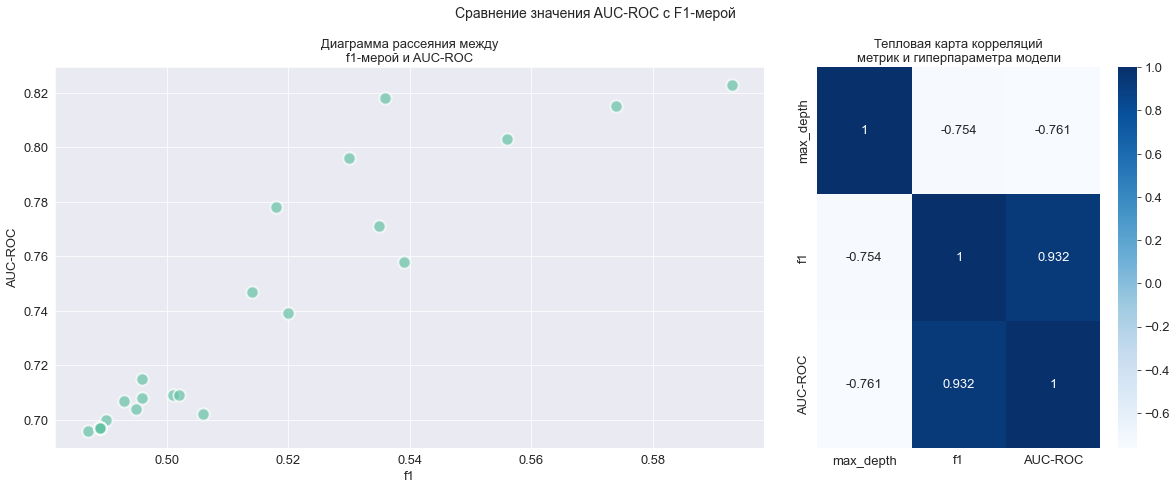

In [78]:
matching_auc_f1(tree_df)

Корреляция между f1 и AUC-ROC положительная и довольно высокая.

#### Случайный лес

Создадим три различных датафрейма для сравнения результатов обученных моделей при различных долях

In [79]:
model_list = ['forest_df_1', 'forest_df_2', 'forest_df_3']
fraction_list = [0.3, 0.45, 0.6]
for i in range(3):    
    locals()[model_list[i]] = forest_func(downsample, fraction_list[i])

Выведем на экран лучшие результаты f1-меры для каждой модели

In [80]:
best_forest_fraction=(pd.merge(forest_df_1.sort_values(by='f1', ascending=False).reset_index(drop=True),
                      pd.merge(forest_df_2.sort_values(by='f1', ascending=False).reset_index(drop=True),
                               forest_df_3.sort_values(by='f1', ascending=False).reset_index(drop=True),
                               left_index=True, right_index=True, suffixes=['_2','_3']),
                               left_index=True, right_index=True)
                      .rename(columns={'n_estimators':'n_estimators_1','f1':'f1_1', 'AUC-ROC':'AUC-ROC_1'}))
best_forest_fraction.head(3)

,n_estimators_1,f1_1,AUC-ROC_1,n_estimators_2,f1_2,AUC-ROC_2,n_estimators_3,f1_3,AUC-ROC_3
0,29,0.608,0.846,29,0.641,0.844,17,0.623,0.843
1,24,0.605,0.845,26,0.637,0.844,16,0.620,0.843
2,9,0.603,0.841,24,0.636,0.845,19,0.619,0.843


Для наглядности отобразим результаты графически в виде трех столбчатых диаграмм в одних осях

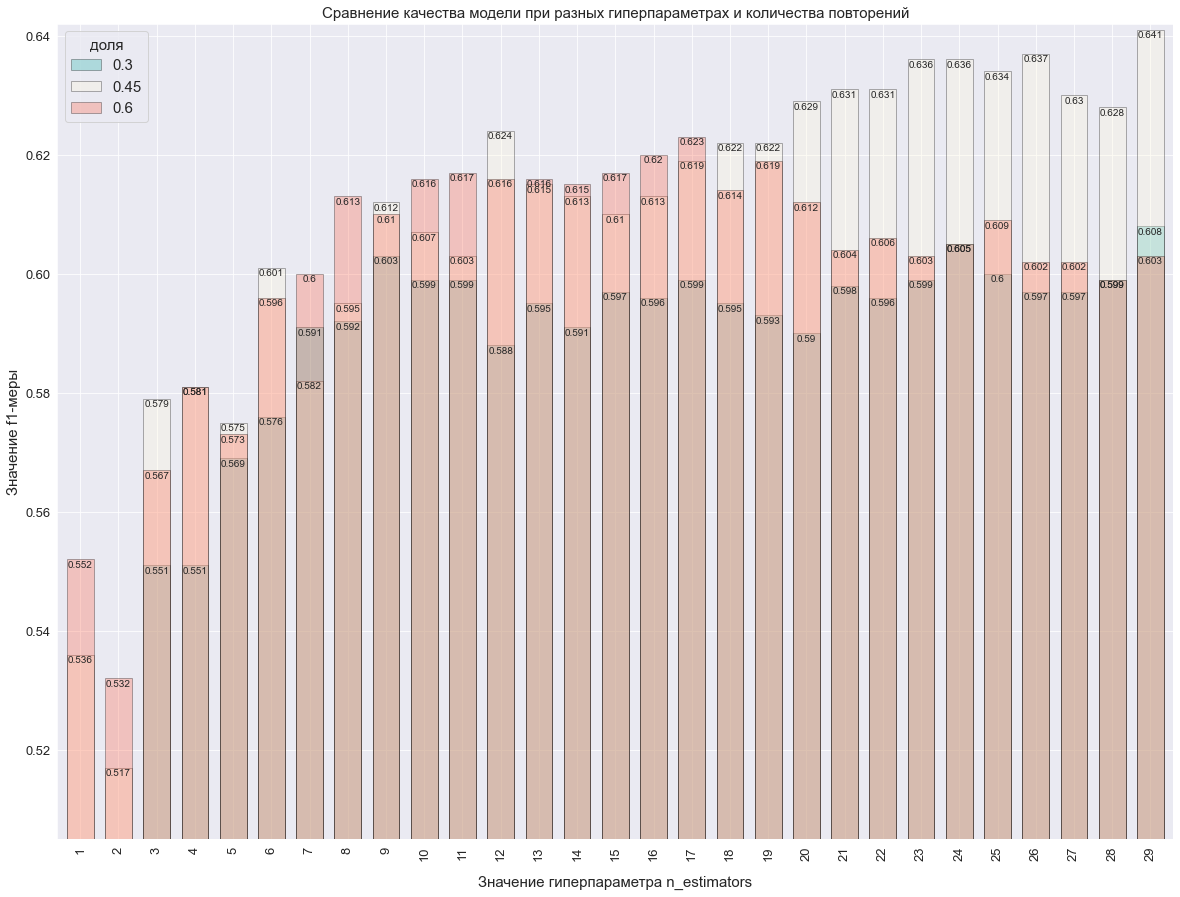

In [81]:
x_param='n_estimators'

colors = ['lightseagreen', 'cornsilk', 'tomato']
plots = ['plot_1','plot_2', 'plot_3']
paddings = [-10, -10, -10]
plt.title('Сравнение качества модели при разных гиперпараметрах и количества повторений', fontsize=15)

for i in range(3):
    ax = plt.gca()
    locals()[plots[i]]=locals()[model_list[i]].plot(kind='bar',
                                                   x=x_param,
                                                   y='f1',
                                                   figsize=(20,15),
                                                   ec='black',
                                                   ax=ax,
                                                   width=0.7,
                                                   color=colors[i],
                                                   fontsize=13,
                                                   alpha=0.3,
                                                   ylim=(0.505, 0.642))
    locals()[plots[i]].bar_label(ax.containers[i], padding=paddings[i], fontsize=10)
    locals()[plots[i]].legend(fraction_list,fontsize=15, title='доля', title_fontsize=15)

plt.xlabel(f'Значение гиперпараметра {x_param}', fontsize= 15, labelpad = 15)    
plt.ylabel('Значение f1-меры', fontsize=15);

- `f1-мера` при лучших гиперпараметре и доле увеличилась относительно модели, полученной техникой upsampling 
- обеспечено требуемое заказчиком значение `f1-меры`⩾0.59
- лучшие результаты при доле 0.45.

Присвоим переменной `forest_df` результаты лучшей модели для сравнения результатов текущей техники

In [82]:
forest_df = forest_df_2

Сравним значения AUC-ROC с F1-мерой графически

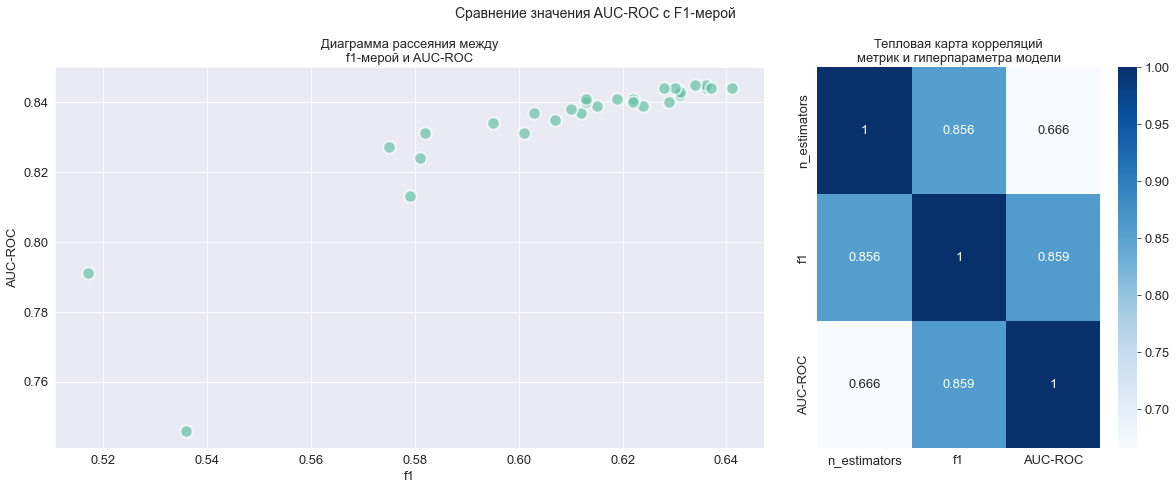

In [83]:
matching_auc_f1(forest_df)

Корреляция между f1 и AUC-ROC положительная и довольно высокая.

#### Логистическая регрессия

Создадим три различных датафрейма для сравнения результатов обученных моделей при различных долях

In [84]:
model_list = ['logistic_df_1', 'logistic_df_2', 'logistic_df_3']
fraction_list = [0.3, 0.45, 0.6]
for i in range(3):    
    locals()[model_list[i]] = logistic_func(downsample, fraction_list[i])

Выведем на экран лучшие результаты f1-меры для каждой модели

In [85]:
best_logistic_fraction=(pd.merge(logistic_df_1.sort_values(by='f1', ascending=False).reset_index(drop=True),
                        pd.merge(logistic_df_2.sort_values(by='f1', ascending=False).reset_index(drop=True),
                                 logistic_df_3.sort_values(by='f1', ascending=False).reset_index(drop=True),
                                 left_index=True, right_index=True, suffixes=['_2','_3']),
                                 left_index=True, right_index=True)
                        .rename(columns={'solver':'solver_1','f1':'f1_1', 'AUC-ROC':'AUC-ROC_1'}))
best_logistic_fraction.head(3)

,solver_1,f1_1,AUC-ROC_1,solver_2,f1_2,AUC-ROC_2,solver_3,f1_3,AUC-ROC_3
0,liblinear,0.499,0.763,newton-cg,0.491,0.761,liblinear,0.433,0.761
1,newton-cg,0.498,0.763,lbfgs,0.491,0.761,newton-cg,0.432,0.761
2,lbfgs,0.498,0.763,liblinear,0.491,0.761,lbfgs,0.432,0.761


- значение `f1-меры` одинаково при любом значении гиперпараметров
- значение `f1-меры` аналогично предыдущей модели логистической регрессии
- лучшая модель при количестве повторений 3
- данная модель не обеспечивает требуемое заказчиком значение `f1-меры` ⩾0.59

Присвоим переменной `logistic_df` результаты лучшей модели для сравнения результатов текущей техники

In [86]:
logistic_df = logistic_df_1

#### Сравнение результатов

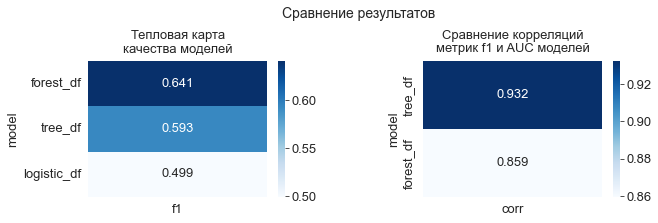

In [87]:
best_results_4 = results_df()
metrics_corr_4 = corr_df()
matching_results(best_results_4, metrics_corr_4) 

Вывод.
- качество при увеличении выборки изменилось немного улучшилось, но не для всех моделей
- наилучшие результаты показала модель **случайный лес**, на втором месте - **дерево решений**, на третьем - **логистическая регрессия**
- модели **случайный лес** и **дерево решений** обеспечивают требуемое заказчиком значение `f1-меры`⩾0.59
- корреляция между f1 и AUC-ROC:
    - для **случайного леса** и **дерева решений** положительная и довольно высокая
    - для **логистической регрессии** значения AUC-ROC и F1-меры постоянны

## Выбор лучшей модели

Сравним тепловые карты качества моделей при разных техниках обучения

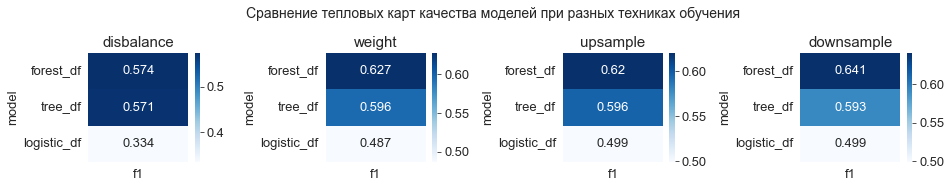

In [88]:
results_list = ['best_results_1', 'best_results_2', 'best_results_3', 'best_results_4']
method_list = ['disbalance', 'weight', 'upsample', 'downsample']
ax_list = ['ax1', 'ax2', 'ax3', 'ax4']

fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, figsize=(15,2))
fig.subplots_adjust(wspace=0.9)
fig.suptitle('Сравнение тепловых карт качества моделей при разных техниках обучения', y = 1.2, fontsize = 14)

for i in range(4):
    sns.heatmap(locals()[results_list[i]].set_index('model').sort_values(by='f1', ascending=False),
                cmap="Blues",
                ax=locals()[ax_list[i]],
                annot=True,
                fmt ='.3g',
                annot_kws={'size':13})
    locals()[ax_list[i]].tick_params(rotation=0)
    locals()[ax_list[i]].set_title(method_list[i], fontsize=15);

Сравним корреляции метрик f1 и AUC моделей при разных техниках обучения

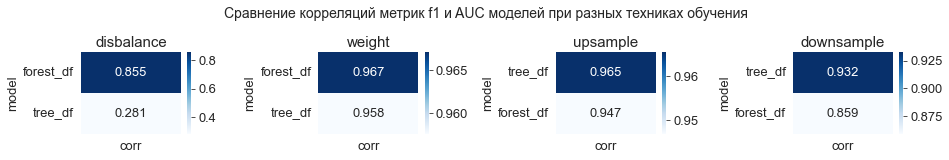

In [89]:
metrics_list = ['metrics_corr_1', 'metrics_corr_2', 'metrics_corr_3', 'metrics_corr_4']

fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, figsize=(15,1.5))
fig.subplots_adjust(wspace=0.9)
fig.suptitle('Сравнение корреляций метрик f1 и AUC моделей при разных техниках обучения', y = 1.3, fontsize = 14)

for i in range(4):
    sns.heatmap(locals()[metrics_list[i]].set_index('model').sort_values(by='corr', ascending=False),
                cmap="Blues",
                ax=locals()[ax_list[i]],
                annot=True,
                fmt ='.3g',
                annot_kws={'size':13})
    locals()[ax_list[i]].tick_params(rotation=0)
    locals()[ax_list[i]].set_title(method_list[i], fontsize=15);

При сбалансированных данных корреляция между метриками заметно выше.

Добавим столбец `'method'` в датафреймы с лучшими результатами (сохранены в переменной `results_list`)

In [90]:
for i in range(4):    
    locals()[results_list[i]]['method'] = pd.Series([method_list[i], method_list[i], method_list[i]])

Объединим датафреймы с лучшими результатами в один датафрейм `compare_results`

In [91]:
compare_results = (best_results_1.merge(best_results_2, on=['model','f1','method'], how='outer')
                                 .merge(best_results_3, on=['model','f1','method'], how='outer')
                                 .merge(best_results_4, on=['model','f1','method'], how='outer'))

Сравним качество всех моделей на тепловой карте

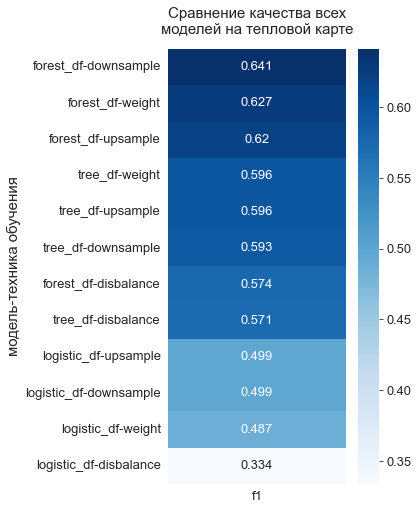

In [92]:
plt.figure(figsize=(4,8))
ax_all=sns.heatmap(compare_results.set_index(['model','method']).sort_values(by='f1', ascending=False),
                   cmap="Blues",
                   annot=True,
                   fmt ='.3g',
                   annot_kws={'size':13}).set_title('Сравнение качества всех\nмоделей на тепловой карте', y = 1.02, fontsize=15);
plt.tick_params(axis='both', labelsize=13)
plt.ylabel('модель-техника обучения', fontsize=15);

Отобразим результаты графически на столбчатой диаграмме

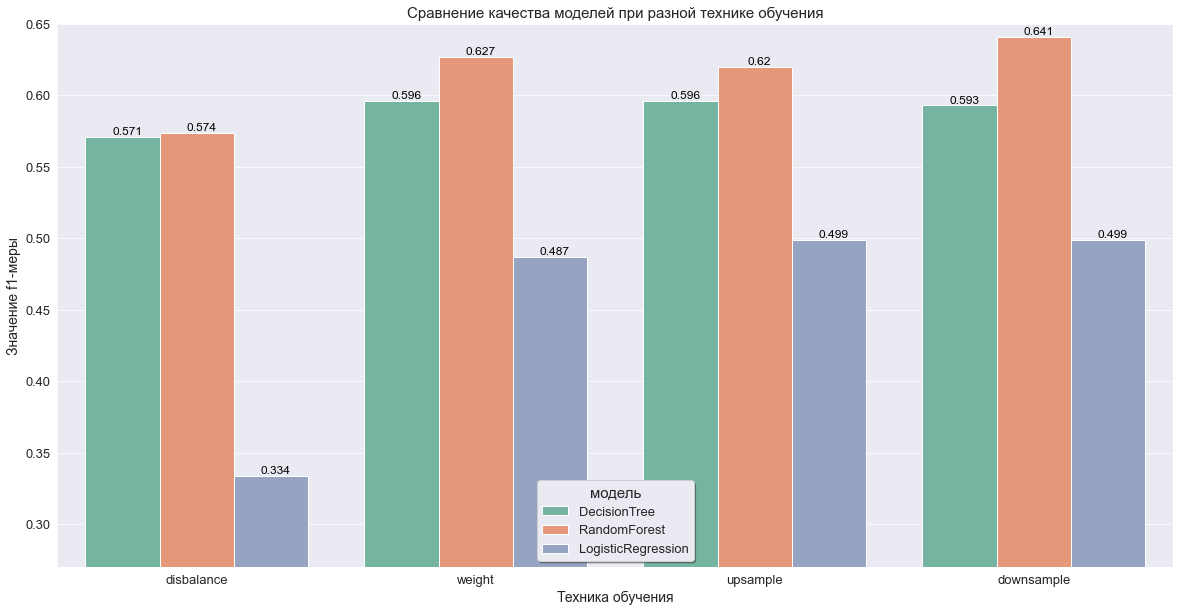

In [93]:
plt.figure(figsize=(20,10))
plt.title('Сравнение качества моделей при разной технике обучения', fontsize=15)
ax=sns.barplot(data=compare_results,
               x='method', 
               y='f1',
               hue='model',
               saturation=.7)

plt.xlabel('Техника обучения', fontsize=14)
plt.ylabel('Значение f1-меры', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set(ylim=(0.27, 0.65))

ax.legend(loc='lower center',fontsize=13, shadow=True, title='модель', title_fontsize=15)
models_name=['DecisionTree', 'RandomForest', 'LogisticRegression']
for i in range(3):
    ax.legend_.texts[i].set_text(models_name[i])

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',
                (p.get_x()+0.15, p.get_height()),
                color='black',
                size=12,
                ha="center",
                va='bottom');

Вывод.
- при всех техниках наилучшие результаты показала модель **случайный лес**, на втором месте - **дерево решений**, на третьем - **логистическая регрессия**
- модели **случайный лес** и **дерево решений** обеспечивают требуемое заказчиком значение `f1-меры`⩾0.59
- модель **логистическая регрессия** не обеспечивает требуемое заказчиком значение `f1-меры`⩾0.59
- наилучшая модель **случайный лес** с техникой обучения **downsampling**

Лучшее значение f1-меры

In [94]:
compare_results[compare_results['f1']==compare_results['f1'].max()]

,model,f1,method
10,forest_df,0.641,downsample


## Оптимизация лучшей модели

Попробуем подобрать гиперпараметры для получения ещё бóльшего значения `f1-меры`

Добавим гиперпараметры 
- `min_samples_split` - минимальное количество выборок, необходимое для разделения внутреннего узла
- `min_samples_leaf`- минимальное количество выборок, необходимое для конечного узла

In [95]:
%%time

f1_best_valid = compare_results['f1'].max()
best_leaf = 0
best_split = 0

features_sampled, target_sampled = downsample(features_train, target_train, 0.45)
split_list = list(range(2,20,3))
leaf_list = list(range(2,15))

for split in split_list:
    for leaf in leaf_list:
        model = RandomForestClassifier(random_state=12345,
                                       max_depth=9,
                                       n_estimators=29,
                                       min_samples_split=split,
                                       min_samples_leaf=leaf) # создание модели с различными значениями n_estimators
        model.fit(features_sampled, target_sampled) # обучение модели на тренировочной выборке
        predicted_valid = model.predict(features_valid) # предсказания на валидационной выборке
        result=f1_score(target_valid, predicted_valid) # f1-мера
        if result > f1_best_valid:
            best_model = model
            f1_best_valid = result
            best_split = split
            best_leaf = leaf
        else:
            best_model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=29) 
f1_best_valid = f1_best_valid.round(3)

CPU times: total: 8.58 s
Wall time: 8.6 s


In [96]:
print(f'f1-мера наилучшей модели на валидационной выборке:{f1_best_valid}\n\
min_samples_split:{best_split}\n\
min_samples_leaf:{best_leaf}')

f1-мера наилучшей модели на валидационной выборке:0.641
min_samples_split:0
min_samples_leaf:0


Модель с наилучшими гиперпараметрами сохранена в переменной `best_model`

In [97]:
best_model

RandomForestClassifier(max_depth=9, n_estimators=29, random_state=12345)

## Метрики лучшей модели

### Матрица ошибок

Посмотрим на графическое отображение матрицы ошибок.

- TP - истинно положительный ответ
- FP - ложноположительный ответ
- TN - истинно отрицательный ответ
- FN - ложноотрицательный ответ

TP, FP, TN, FN собираются в одну таблицу — матрицу ошибок, или матрицу неточностей (англ. сonfusion matrix).

Матрица формируется так:
- по горизонтали («Предсказания») располагаются метки алгоритма от 0 до 1;
- по вертикали («Ответы») — истинные метки класса от 0 до 1.
Что получаем:
1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:
- TN в левом верхнем углу;
- TP в правом нижнем углу.
2. Вне главной диагонали — ошибочные варианты:
- FP в правом верхнем углу;
- FN в левом нижнем углу.

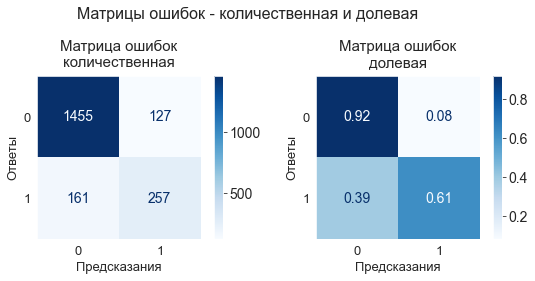

In [98]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,3))

fig.subplots_adjust(wspace=0, hspace=0)

fig.suptitle('Матрицы ошибок - количественная и долевая', y = 1.2, fontsize = 16)

plt.rcParams['font.size'] = '14'
best_model.fit(features_sampled, target_sampled)
predicted_valid = best_model.predict(features_valid)

cm1 = confusion_matrix(target_valid, predicted_valid, labels=best_model.classes_, normalize=None)
cm2 = confusion_matrix(target_valid, predicted_valid, labels=best_model.classes_, normalize='true')

disp = ['disp1','disp1']
cm = ['cm1','cm2']
axes = ['ax1','ax2']
titles = ['Матрица ошибок\nколичественная', 'Матрица ошибок\nдолевая']

for i in [0,1]:
    locals()[disp[i]] = ConfusionMatrixDisplay(confusion_matrix=locals()[cm[i]],
                                               display_labels=best_model.classes_)    
    locals()[disp[i]].plot(include_values=True, cmap='Blues', ax=locals()[axes[i]]);
    
    locals()[disp[i]].ax_.set_title(titles[i], fontsize=15, y = 1.02)
    locals()[disp[i]].ax_.set_ylabel('Ответы')
    locals()[disp[i]].ax_.set_xlabel('Предсказания')
    locals()[disp[i]].ax_.grid(False);

Матрица ошибок даёт понимание, какими будут полнота (recall) и точность (precision) модели.

Но данные метрики можно вычислить и при помощи готовых функций.

### Полнота

<ins>**Полнота (Recall)**</ins> выявляет, какую долю положительных среди всех ответов выделила модель.

Обычно они на вес золота, и важно понимать, как хорошо модель их находит.

Recall рассчитывается по формуле:

***Recall=TP/(TP+FN)***

In [99]:
print(f'полнота лучшей модели: {recall_score(target_valid, predicted_valid).round(3)}')

полнота лучшей модели: 0.615


### Точность

<ins>**Точность (Precision)**</ins> определяет, как много отрицательных ответов нашла модель, пока искала положительные.

Чем больше отрицательных, тем ниже точность.

Точность рассчитывается по формуле:

***Precision=TP/(TP+FP)***

In [100]:
print(f'точность лучшей модели: {precision_score(target_valid, predicted_valid).round(3)}')

точность лучшей модели: 0.669


### Вероятность класса

Для дальнейшей визуализации изменений метрик при изменении порога классификации (по умолчанию = 0.5) вычислим вероятность класса 1.

In [101]:
probabilities_valid = best_model.predict_proba(features_valid) # функция вычисления вероятности классов
probabilities_one_valid = probabilities_valid[:, 1] # вероятность класса 1
probabilities_one_valid[:5]

array([0.08845856, 0.57873397, 0.48583272, 0.22029738, 0.08081565])

### PR-кривая

Посмотрим графически как изменяются точность и полнота при изменении порога классификации (по умолчанию он равен 0.5)

На графике по вертикали наносится значение точности, по горизонтали — полноты.

Кривая, показывающая их значения, называется PR-кривой (от англ. Precision и Recall).

Чем выше кривая, тем лучше модель.

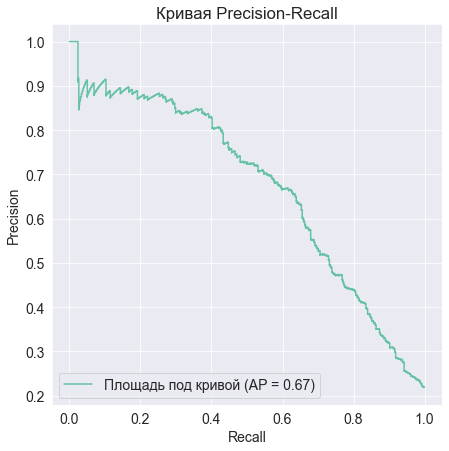

In [102]:
fig, ax = plt.subplots(figsize=(7,7))
PrecisionRecallDisplay.from_predictions(target_valid, probabilities_one_valid, name='Площадь под кривой', ax=ax)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall')
plt.show() 

F1-мера - это среднее гармоническое полноты и точности. Единица в F1 означает, что соотношение полноты и точности равно 1:1.
Если положительный класс плохо прогнозируется по одной из шкал (Recall или Precision), то близкая к нулю F1-мера покажет, что прогноз класса 1 не удался.

Значения полноты и точности при лучшем значении f1-меры подсчитаны выше.

### ROC-кривая

Доля верно предсказанных объектов к общему числу объектов класса называется TPR (англ. True Positive Rate) или «полнота», а на английском используют термин recall.

Формула выглядит так: *TPR=TP/(TP + FN)*.

Доля ложных срабатываний к общему числу объектов за пределами класса (англ. False Positive Rate, FPR) вычисляется аналогично. Это отношение FP-ответов (англ. False Positives — отрицательные, классифицированные как положительные) к сумме отрицательных ответов: FP и TN (англ. True Negatives — верно классифицированные отрицательные ответы).

Формула выглядит так: *FPR=FP/(FP+TN)*

Деления на ноль не будет: в знаменателях значения, которые постоянны и не зависят от изменения модели.

Изобразим его на графике соотношение TPR и FPR.

По горизонтали нанесём долю ложноположительных ответов (FPR), а по вертикали — долю истинно положительных ответов (TPR).

Переберём значения порога и проведём кривую. Она называется ROC-кривая, или кривая ошибок (от англ. receiver operating characteristic, «характеристика работы приёмника»; термин пришёл из теории обработки сигналов).
Для модели, которая всегда отвечает случайно, ROC-кривая выглядит как прямая, идущая из левого нижнего угла в верхний правый. 

Чем график выше, тем больше значение TPR и лучше качество модели.

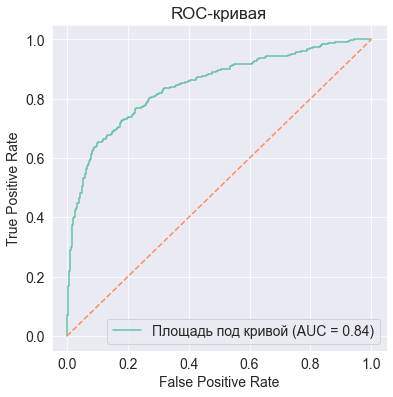

In [103]:
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(target_valid, probabilities_one_valid, name='Площадь под кривой',ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

ROC-кривая предназначен для многих различных уровней пороговых значений.

Вы можете думать об этом как о мере точности и отзыва при определенном пороговом значении, тогда как AUC - это площадь под кривой ROC. Чтобы оценка F была высокой, должны быть высокими и точность, и отзывчивость.

### AUC-ROC

Чтобы выявить, как сильно модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC (от англ. Area Under Curve ROC, «площадь под ROC-кривой»). AUC-ROC случайной модели равна 0.5.

In [104]:
print(f'AUC-ROC лучшей модели: {roc_auc_score(target_valid, probabilities_one_valid).round(3)}')

AUC-ROC лучшей модели: 0.844


## Финальное тестирование

### Проверка качества модели на тестовой выборке

In [105]:
best_model.fit(features_sampled, target_sampled) # обучение модели на тренировочной выборке
predicted_test = model.predict(features_test) # предсказания на тестовой выборке
f1_best_test = f1_score(target_test, predicted_test).round(3) # f1-мера
print(f'f1-мера тестовой выборки: {f1_best_test}') 
if f1_best_test >= 0.59:
    print('обеспечено требуемое заказчиком значение f1-меры ⩾0.59')
else:
    print('не обеспечено требуемое заказчиком значение f1-меры ⩾0.59')

f1-мера тестовой выборки: 0.595
обеспечено требуемое заказчиком значение f1-меры ⩾0.59


### Cравнение лучшей модели со случайной

Используем классификатор `DummyClassifier`, делающий прогнозы, игнорируя входные функции.

Конкретное поведение базовой линии выбирается с помощью параметра `strategy`.

In [106]:
clf_dummy = DummyClassifier(strategy='stratified', random_state=12345)
clf_dummy.fit(features_sampled, target_sampled) # обучение
predicted_valid = clf_dummy.predict(features_valid) # предсказания 
f1_dum_valid = f1_score(target_valid, predicted_valid).round(3)
predicted_test = clf_dummy.predict(features_test) # предсказания
f1_dum_test = f1_score(target_test, predicted_test).round(3)
print('f1-мера случайной модели на валидационной выборке:', f1_dum_valid)
print('f1-мера случайной модели на тестовой выборке:', f1_dum_test)

f1-мера случайной модели на валидационной выборке: 0.243
f1-мера случайной модели на тестовой выборке: 0.251


In [107]:
f1_compare_1 = (pd.DataFrame({'f1':                   [f1_best_valid,
                                                       f1_dum_valid,
                                                       f1_best_test,
                                                       f1_dum_test],
                                    'model_selection':['best_valid',
                                                       'dummy_valid',
                                                       'best_test',
                                                       'dummy_test']})
                     .set_index('model_selection'))
f1_compare_1

,f1
model_selection,
best_valid,0.641
dummy_valid,0.243
best_test,0.595
dummy_test,0.251


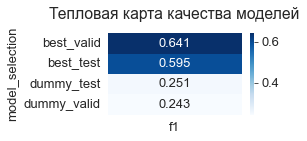

In [108]:
plt.figure(figsize=(3,1.5))
plt.rcParams['font.size'] = '13'
plt.title('Тепловая карта качества моделей', y=1.1)
sns.heatmap(f1_compare_1.sort_values(by='f1', ascending=False),
            annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g');

`model_selection`:
- `best_valid` - лучшая модель, валидационная выборка
- `best_test` - лучшая модель, тестовая выборка
- `dummy_valid` - dummy модель, валидационная выборка
- `dummy_test` - dummy модель, тестовая выборка

Итог.

Лучшая модель показала более высокую точность, чем случайная, следовательно лучшая модель вменяема.

### Проверка лучшей модели на константной выборке

Проверим точность при константном заполнении целевого признака.

Создадим переменные для целевого признака константной выборки (все значения "1")

In [109]:
predicted_valid_const = pd.Series(1, index=target_valid.index)
predicted_test_const = pd.Series(1, index=target_valid.index)

In [110]:
f1_const_valid = f1_score(target_valid, predicted_valid_const).round(3)
f1_const_test = f1_score(target_test, predicted_test_const).round(3)
print('f1-мера на валидационной выборке:', f1_const_valid)
print('f1-мера на тестовой выборке:', f1_const_test)

f1-мера на валидационной выборке: 0.346
f1-мера на тестовой выборке: 0.349


In [111]:
accuracy_compare_2 = (pd.DataFrame({'f1':       [f1_best_valid,
                                                 f1_const_valid,
                                                 f1_best_test,
                                                 f1_const_test],
                                    'selection':['act_valid',
                                                 'const_valid',
                                                 'act_test',
                                                 'const_test']})
                    .set_index('selection'))
accuracy_compare_2

,f1
selection,
act_valid,0.641
const_valid,0.346
act_test,0.595
const_test,0.349


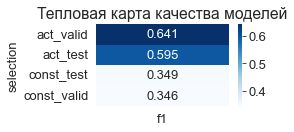

In [112]:
plt.figure(figsize=(3,1.5))
plt.title('Тепловая карта качества моделей')
sns.heatmap(accuracy_compare_2.sort_values(by='f1', ascending=False),
            annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g');

`selection`:
- `act_valid` - актуальный датасет, валидационная выборка
- `act_test` - актуальный датасет, тестовая выборка
- `const_valid` - константный датасет, валидационная выборка
- `const_test` - константный датасет, тестовая выборка

Итог.

Лучшая модель, проверенная на актуальных данных, показала более высокую точность, чем лучшая модель, проверенная на константных данных, следовательно модель вменяема.

## Вывод

По требованию заказчика построена модель для задачи классификации, прогнозирующая, уйдёт ли клиент из банка в ближайшее время или нет.

Значение *F1*-меры не ниже 0.59, точность проверена на тестовой выборке.

Корреляция между метриками F1-мерой и AUC-ROC положительная, при сбалансированных данных - заметно выше.

Модель сохранена в переменной `best_model`.

In [113]:
best_model

RandomForestClassifier(max_depth=9, n_estimators=29, random_state=12345)